## Import necessary libraries & download dataset

In [ ]:
import nltk
import re
import regex
import os
from functools import reduce

nltk.download('punkt')
os.chdir("/content/")
!git clone https://github.com/nmng108/ComOM.git

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cloning into 'ComOM'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 135 (delta 47), reused 82 (delta 1), pack-reused 0
Receiving objects: 100% (135/135), 9.49 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
# !pip install transformers
# !git clone --single-branch --branch fast_tokenizers_BARTpho_PhoBERT_BERTweet https://github.com/datquocnguyen/transformers.git
# !pip install -e "/content/transformers"
# !pip install underthesea

In [ ]:
# import underthesea as uts
# from underthesea import word_tokenize, sent_tokenize

In [ ]:
# Test libraries's APIs
# Conclusion 1: both the NLP libs (nltk, uts) cannot sent_tokenize correctly in a sentence containing citations.
# uts.word_tokenize("   2.   A noi: \"Samsung Galaxy Y10 Plus co kich thứơc man hinh 2.8mm, kha an tuong vi nho hon dang ke.\", va dung nhu vay.")


In [ ]:
# !pip install py_vncorenlp

In [ ]:
# import py_vncorenlp
# import os

# # Automatically download VnCoreNLP components from the original repository
# # and save them in some local machine folder
# os.mkdir('/content/vncorenlp')
# py_vncorenlp.download_model(save_dir='/content/vncorenlp')

# # Load the word and sentence segmentation component
# rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/vncorenlp')

In [ ]:
# text = "title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?"
# output = rdrsegmenter.word_segment(text)

# output
# # ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

### Load the Vietnamese stopword list

In [ ]:
abs_path: str = "/content/ComOM/vietnamese-stopwords.txt"

if not os.path.isfile(abs_path):
  print(f"Cannot load set of stopwords as the file \"{abs_path}\" is not found")
  exit(-1)

try:
  with open(abs_path, mode="r") as file:
    global stopwords
    stopwords = file.read().split("\n")
    stopwords = set([w.lower() for w in stopwords])

except Exception as e:
  print(f"Error raised while reading {abs_path}: {str(e)}")

print(f"Loaded {len(stopwords)} stopwords in \"{abs_path}\"")

Loaded 1942 stopwords in "/content/ComOM/vietnamese-stopwords.txt"


# A. Load & parse data

### Sample training dataset

In [ ]:
# Used for quick tests without importing/reading files
sample_dataset: str = """
title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?

Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn?	Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn ?

Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple.	Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple .

Do đó, ngay khi Samsung Z Fold 4 được trình làng, model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max.	Do đó , ngay khi Samsung Z Fold 4 được trình làng , model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max .

Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4.	Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4 .
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["1&&Thiết", "2&&kế"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["4&&kích", "5&&thước", "6&&màn", "7&&hình"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}

alt: Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn	alt : Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn

des:	des :

alt: so-sanh-thong-so-cau-hinh-galaxy-z-fold-4-va-iphone-13-pro-max-xtmobile	alt : so-sanh-thong-so-cau-hinh-galaxy-z-fold - 4 - va-iphone - 13 - pro-max-xtmobile

6.  6.

Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE, giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn.	Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE , giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn .
{"subject": ["12&&Galaxy", "13&&S20", "14&&FE"], "object": ["28&&Galaxy", "29&&S20"], "aspect": ["32&&mức", "33&&giá"], "predicate": ["34&&rẻ", "35&&hơn"], "label": "COM+"}

T
"""

# nltk.word_tokenize(nltk.line_tokenize(sample_dataset)[0])


## I. Load from files

In [ ]:
# Make sure that you have pull the git repository (first step)
TRAINING_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_training_v2"
DEVELOPMENT_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_public_test_golden"
TEST_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_public_test_nolabel/VLSP2023_ComOM_public_test_nolabel"

In [ ]:
def load_dataset(data_directory: str = TRAINING_DATASET_DIR, separates_lines: bool = True) -> list:
  """ Should not set separates_lines = False """
  result: list = []

  if not os.path.isdir(data_directory):
    print("Loading dataset has failed. Load sample dataset instead")
    # May use sample dataset instead
    return sample_dataset

  for parent_dir_path, dirnames, filenames in os.walk(data_directory):
    for filename in filenames:
      if not filename.endswith(".txt"): continue

      abs_path: str = os.path.join(parent_dir_path, filename)

      try:
        with open(abs_path, mode = 'r') as file:
          text = file.read()

          if separates_lines: result.extend(text.split("\n"))
          else: result.append(text)

      except Exception as e:
        print(f"Error raised while reading {filename}: {str(e)}")

  return result

load_dataset(separates_lines=False)[0]

'title: Có nên mua Samsung Galaxy S22 Ultra thời điểm này? Câu trả lời là…\ttitle : Có nên mua Samsung Galaxy S22 Ultra thời điểm này ? Câu trả lời là …\n\nSamsung Galaxy S22 Ultra là sản phẩm tốt nhất thế giới Android hiện nay.\tSamsung Galaxy S22 Ultra là sản phẩm tốt nhất thế giới Android hiện nay .\n{"subject": ["1&&Samsung", "2&&Galaxy", "3&&S22", "4&&Ultra"], "object": [], "aspect": [], "predicate": ["8&&tốt", "9&&nhất", "10&&thế", "11&&giới", "12&&Android", "13&&hiện", "14&&nay"], "label": "SUP+"}\n\nĐiều này không cần bàn luận gì thêm.\tĐiều này không cần bàn luận gì thêm .\n\nTuy nhiên, chỉ có một câu hỏi đặt ra: Liệu có nên mua Galaxy S22 Ultra ngay thời điểm này?\tTuy nhiên , chỉ có một câu hỏi đặt ra : Liệu có nên mua Galaxy S22 Ultra ngay thời điểm này ?\n\nHi vọng bài viết sau đây của Hoàng Hà Mobile sẽ giúp khách hàng đang quan tâm về siêu phẩm này sẽ có sự lựa chọn chính xác!\tHi vọng bài viết sau đây của Hoàng Hà Mobile sẽ giúp khách hàng đang quan tâm về siêu phẩm này

## II. Parse dataset

### 1. **Modeling classes**

In [ ]:
class Quintuple():
  """
    Represent a quintuple.
  """

  def __init__(self, *args):
    """
      Should not use this constructor directly.
      You can use either of the 2 static methods below.
    """

    if len(args) == 1 and isinstance(args[0], dict):
      self.subject = args[0].get('subject')
      self.object = args[0].get('object')
      self.aspect = args[0].get('aspect')
      self.predicate = args[0].get('predicate')
      self.label: str = args[0].get('label')

    elif len(args) == 5:
      self.subject = args[0]
      self.object = args[1]
      self.aspect = args[2]
      self.predicate = args[3]
      self.label: str = args[4]

    else: raise ValueError("Constructing Quintuple instance got failed.")

  @staticmethod
  def fromDict(obj: dict):
    return Quintuple(obj)

  @staticmethod
  def fromValues(subject: str | None, _object: str | None, aspect: str | None, predicate: str, label: str):
    return Quintuple(subject, _object, aspect, predicate, label)

  def toDict(self) -> dict:
    return {
      'subject': self.subject,
      'object': self.object,
      'aspect': self.aspect,
      'predicate': self.predicate,
      'label': self.label
    }

class DataPointBase():
  def __init__(self, sentence: str | dict | list):
    assert isinstance(sentence, str | dict | list), (
        "Sentence must be either of [str | dict | list]"
    )

    self.sentence = sentence

  def toDict(self) -> dict:
    return {'sentence': self.sentence}

class DataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    a *single* quintuple (if any).
  """

  def __init__(self, sentence: str | dict | list, quintuple: Quintuple | str):
    super().__init__(sentence)

    assert quintuple is None or isinstance(quintuple, Quintuple | str), (
        "quintuple must be either of [Quintuple | str | None]"
    )

    self.quintuple = quintuple

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()

    if not self.quintuple is None:
      result_dict.update(
          {'quintuple': self.quintuple} if isinstance(self.quintuple, str)
          else self.quintuple.toDict()
      )

    return result_dict

class MultiQuintuplesDataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    *multiple* quintuples.

    This should be the result data type of parsing dataset.
  """

  def __init__(self, sentence: str | dict | list, quintuples: list | None):
    super().__init__(sentence)

    assert quintuples is None or (
        isinstance(quintuples, list) and all([isinstance(q, Quintuple | str) for q in quintuples])
    ), (
        "quintuples must be a list of [Quintuple | str] or None"
    )

    self.quintuples = quintuples

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()
    quintuples = None if self.quintuples is None else (
        [q.toDict() if isinstance(q, Quintuple) else q for q in self.quintuples]
    )

    result_dict.update({'quintuples': quintuples})

    return result_dict

  def addQuintuple(self, quintuples: Quintuple | str | list):
    if isinstance(quintuples, list):
      self.quintuples.extend(quintuples)
    else:
      self.quintuples.append(quintuples)

  def toSeparateDataPoints(self) -> list[DataPoint]:
    """ Returns a list of DataPoint """
    if not self.quintuples is None and len(self.quintuples) > 0:
      return [DataPoint(self.sentence, q) for q in self.quintuples]

    return [DataPoint(self.sentence, None)]

class Dataset():
  """
    Alternative of DatasetUtils (below); need to be instantiated before use

    This stores a list of MultiQuintuplesDataPoint objects.
  """

  def __init__(self, multi_quin_dataset: list[MultiQuintuplesDataPoint]):
    self.__dataset: list[MultiQuintuplesDataPoint] = multi_quin_dataset

  def get(self) -> list[MultiQuintuplesDataPoint]: return self.__dataset

  def toMultiQuintuplesDictList(self, min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(self.__dataset, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in self.__dataset]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in self.__dataset]
    )))

  def toDictList(self) -> list[dict]:
    """ Convert DataPoint list to dict list """
    data_point_list: list[DataPoint] = self.MultiQuintuplesDataPoints_to_DataPoints(self.__dataset)

    return [d.toDict() for d in data_point_list]

  def convertMultiQuinToSingleQuin(self) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in self.__dataset:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list

class DatasetUtils():
  """ Alternative of the Dataset class; only includes static methods """

  @staticmethod
  def to_multi_quintuples_dict_list(data_point_list: list[MultiQuintuplesDataPoint],
                                    min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(data_point_list, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in data_point_list]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in data_point_list]
    )))

  @staticmethod
  def toDictList(data_point_list: list[DataPoint]) -> list[dict]:
    """ Convert DataPoint list to a dict list """
    assert all([isinstance(d, DataPoint) for d in data_point_list]), (
        "Input must be a list of DataPoint instances"
    )

    return [d.toDict() for d in data_point_list]

  @staticmethod
  def MultiQuintuplesDataPoints_to_DataPoints(data_point_list: list[MultiQuintuplesDataPoint]) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in data_point_list:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list


# test
DatasetUtils.toDictList([DataPoint("abc sent", Quintuple.fromValues("fs", "fdsj", None, None, None))])

[{'sentence': 'abc sent',
  'subject': 'fs',
  'object': 'fdsj',
  'aspect': None,
  'predicate': None,
  'label': None}]

### 2. ``parse_data(dataset_array: list): list`` (main function)
- Output:
  ```python
  [{
    "sentence": "...",
    "quintuples": "{...}"
  },]
  # or
  [<MultiQuintuplesDataPoint instance>,]
  ```

In [ ]:
from multipledispatch import dispatch

@dispatch(list)
def parse_data(dataset_array: list[str] = []) -> list[MultiQuintuplesDataPoint]:
  assert all([not "\n" in line for line in dataset_array]), (
      "Provided dataset_array's elements must be single lines and do not contains '\n'"
  )

  result_dataset_list: list = [] # the list to be returned

  for i in range(0, len(dataset_array)):
    current_line = dataset_array[i].strip()

    # Stop considering a line if it is empty or a label (which has JSON format)
    if len(current_line) == 0 or re.match(r"\{.*\}", current_line): continue # regex may be more concrete

    sentences = current_line.split("\t")

    if len(sentences) < 1 or len(sentences[0].strip()) == 0: continue

    dest_sentence = sentences[0].strip() if len(sentences) < 2 else sentences[1].strip()
    # dest_sentence = sentences[1].strip() if len(sentences) >= 2 else None # tmp

    """ Create data point """
    data_point = MultiQuintuplesDataPoint(dest_sentence, None)

    # Check if any corresponding label (quintuple) exists in the following lines
    # and append them to a list
    j = i + 1
    quintuples: list = []

    while j < len(dataset_array) and re.match(r'\{.*\}', dataset_array[j]):
      quintuples.append(dataset_array[j])
      # result_dataset_list.append(data_point.copy()) # old

      j += 1

    result_dataset_list.append(data_point)
    data_point.quintuples = quintuples if len(quintuples) > 0 else None
    """"""

    ## TEST: compare tokenizing between 2 sentences ##
    # if len(sentences) > 1:
    #   tokens_s0 = nltk.word_tokenize(sentences[0])
    #   tokens_s1 = nltk.word_tokenize(sentences[1])
    #   # compare the number of token
    #   if len(tokens_s0) != len(tokens_s1) and sentences[0].find("+") >= 0:
    #     print(f"\nSent 0:{tokens_s0}' ({len(tokens_s0)})")
    #     print(f"Sent 1:{tokens_s1}' ({len(tokens_s1)})")
    #     if len(quintuples) > 0:
    #       print(f"{quintuples}\n")
    ####

  return result_dataset_list

@dispatch(str)
def parse_data(dataset: str = "") -> list:
  # split by "\n" to sequentially read each line of the input
  return parse_data(dataset.split("\n"))

# test
# test_list = parse_data(load_dataset(separates_lines=False)[1])
# DatasetUtils.to_multi_quintuples_dict_list(test_list, 3)
# test_list = parse_data(load_dataset(separates_lines=True))

### 3. Sub-functions of `convert_dataset_representation()`

#### a. ``deserialize(obj_string: str)``
Converts JSON to a dict

- Output: ``{'subject': "", 'object': "", 'aspect': "", 'predicate': "", 'label': ""}``

In [ ]:
import json

def deserialize(obj_string: str) -> Quintuple:

  if obj_string == None or len(obj_string) == 0:
    return

  try:
    obj = json.loads(obj_string)

    return Quintuple.fromDict(obj)

  except json.JSONDecodeError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

  except ValueError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

### TEST ###
test_list = parse_data(load_dataset(separates_lines=False)[1])

min_q = 2

# Dataset(test_list).toMultiQuintuplesDictList(min_q)
# DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)

[deserialize(Dataset(test_list).toMultiQuintuplesDictList(min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]
# [deserialize(DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]

[{'subject': ['6&&Galaxy', '7&&Z', '8&&Flip', '9&&4'],
  'object': ['17&&những',
   '18&&chiếc',
   '19&&điện',
   '20&&thoại',
   '21&&bình',
   '22&&thường'],
  'aspect': [],
  'predicate': ['14&&trông', '15&&giống', '16&&như'],
  'label': 'EQL'},
 {'subject': ['11&&Find', '12&&N2', '13&&Flip'],
  'object': ['17&&những',
   '18&&chiếc',
   '19&&điện',
   '20&&thoại',
   '21&&bình',
   '22&&thường'],
  'aspect': [],
  'predicate': ['14&&trông', '15&&giống', '16&&như'],
  'label': 'EQL'}]

#### b. ``parse_indexed_word_list(quintuple_field: list): dict``

Converts original list of words of each quintuple field into the new form as follow:
  - Input: ``["12&&Galaxy", "13&&S20", "14&&FE"]``
  - Output: 1 of 3 formats below; by default: ``[str] "Galaxy S20 FE"``

Used by ``parse_quintuple_word_lists(quintuple_field)`` (below)

##### sub-function

In [ ]:
class IndexedWord():
  def __init__(self, index, word):
    self.index = index
    self.word = word

  def toDict(self):
    return {self.index: self.word}


def parse_indexed_word(indexed_word: str) -> IndexedWord | None:
  """
    (sub-function)
    Input: <index>&&<word>
    Output: [dict] {<index>: <word>} or None if the input is malformed or None
  """
  if not (isinstance(indexed_word, str) and re.match("^\d*&&.*$", indexed_word)):
    print(f"The word '{indexed_word}' is None or malformed.")
    return

  try:
    parts: list = indexed_word.split("&&")

    if len(parts) != 2: raise ValueError("invalid")

    # return {int(parts[0]): parts[1]}
    return IndexedWord(int(parts[0]), parts[1])

  # Mostly not happen
  except ValueError as err:
    print(f"'{parts[0]}' (in '{indexed_word}') is malformed.")
    return

##### Format 1: `[str] "Galaxy S20 FE"` (default)

In [ ]:
"""
    Main function (in this section).
    - Input: a list of indexed word; an input indexed word should have the
            original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
    - Output: [str] "..."
"""
def parse_indexed_word_list(quintuple_field: list):
  if not isinstance(quintuple_field, list): return # if None

  result_word_list: list = list()

  for word in quintuple_field:
    if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
      print(f"The word '{word}' is None or malformed.")
      continue

    parsed_element = parse_indexed_word(word)
    # may be None
    if parsed_element == None: pass

    result_word_list.append(parsed_element.word) # get word only

  return " ".join(result_word_list)

parse_indexed_word_list(["3&&sdf", "5&&wjfal"])

'sdf wjfal'

##### Format 2: `[dict] {12: "Galaxy", 13: "S20", 14: "FE"}`

In [ ]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [dict] {<index>: "<word>", ...}
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = dict()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.update(parsed_element.toDict())

#   return result_word_list

##### Format 3: `[list] [{12: "Galaxy"}, {13: "S20"},]`

In [ ]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [list] [{<index>: "<word>"}, ...]
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = list()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.append(parsed_element.toDict())

#   return result_word_list

#### c. ``parse_quintuple_word_lists(quintuple: dict, stringified: bool = False) -> dict``
- Output: new quintuple with parsed word lists.

Dependency: ``parse_indexed_word_list(quintuple_field: list): dict``

In [ ]:
"""
    Parse provided word lists in a quintuple (consist of subject, object, aspect & predicate)
    and convert each list to a dict of indexed .
    - Original element: "<index>&&<word>"
    - New element: {<index>: "<word>"}
"""
def parse_quintuple_word_lists(quintuple: dict | Quintuple, stringified: bool = False) -> Quintuple:
  if not isinstance(quintuple, dict | Quintuple):
    print("Input quintuple must be of type 'dict' or 'Quintuple'.")
    return

  result_quintuple: dict = quintuple.copy() if isinstance(quintuple, dict) else quintuple.toDict()

  # subject
  subject = parse_indexed_word_list(result_quintuple['subject'])
  if stringified: subject = str(subject)

  # object
  obj = parse_indexed_word_list(result_quintuple['object'])
  if stringified: obj = str(obj)

  # aspect
  aspect = parse_indexed_word_list(result_quintuple['aspect'])
  if stringified: aspect = str(aspect)

  # predicate
  predicate = parse_indexed_word_list(result_quintuple['predicate'])
  if stringified: predicate = str(predicate)


  # assign all of them
  result_quintuple['subject'] = subject
  result_quintuple['object'] = obj
  result_quintuple['aspect'] = aspect
  result_quintuple['predicate'] = predicate

  return Quintuple.fromDict(result_quintuple)

#### d. ``sequence_to_word_list(sentence: str, stringified: bool = False) -> dict | str``

Convert a sequence/sentence into a ``dict`` containing indexed tokens,
where each element has either of the formats below.

Dependency: ``nltk.word_tokenize()``

##### Format 1: `[str] "..."` - keep the input unchanged and return it (default)

In [ ]:
"""
    Convert a sentence into a list of words.
    Input: a string, which should be a sentence.
    Output: [str] "..."
    Dependency: nltk.word_tokenize()
"""
def sequence_to_word_list(sentence: str, stringified: bool = False):
  return sentence

##### Format 2: `[dict] {<index>: "<word>", ...}`

In [ ]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [dict] {<index>: "<word>", ...}
#     Dependency: nltk.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = nltk.word_tokenize(sentence)
#   result = dict()

#   for j in range(0, len(sentence_words)): result.update({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

##### Format 3:`[list] [{<index>: "<word>"}, ...]`

In [ ]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [list] [{<index>: "<word>"}, ...]
#     Dependency: underthesea.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = uts.word_tokenize(sentence)
#   result = list()

#   for j in range(0, len(sentence_words)): result.append({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

### 4. `convert_dataset_representation(dataset_array: list[MultiQuintuplesDataPoint], stringified: bool = False) -> list`
Convert dataset representation, which consist of deserializing JSON (quintuple) & formating word lists.
  - **Input**:
    - dataset_list: a list of MultiQuintuplesDataPoint objects that has the following format:
    ```python
      {
        'sentence': "Galaxy S20...",
        'quintuples': ['{\"subject\": [\"1&&Galaxy\", \"2&&S20\"],...}',]
      }
    ```

    - **stringified**: boolean param, which determines whether all the *non-hashable* values (list, dict...) are converted to string or not.

  - **Output**: a list of MultiQuintuplesDataPoint objects that have the following format:
    ```python
      {
        'sentence': {1: "Galaxy", 2: "S20", ...}, # or simply original string
        'quintuples': [{
          'subject': {1: "Galaxy", 2: "S20"},
          'object': {1: "Galaxy", 2: "S21"},
          'aspect': {1: "Thiết", 2: "kế"},
          'predicate': {1: "đẹp", 2: "hơn"},
          'label': "COM+"
        },]
      },
    ```

Dependencies:
- `deserialize(obj_string)`
- `parse_quintuple_word_lists(quintuple)`
- `sequence_to_word_list(sequence)`

In [ ]:
""" Main function in this section """
def convert_dataset_representation(dataset_list: list[MultiQuintuplesDataPoint], stringified: bool = False):
  """
    Note that this function will modify data directly on input (dataset_list), thus
    there'is no output
    (param) dataset_list: list of MultiQuintuplesDataPoint
  """
  # result_dataset_list: list = DatasetUtils.to_multi_quintuples_dict_list(dataset_list)

  for data_point in dataset_list:
    # Assign refs to local variable
    quintuples: list = data_point.quintuples

    # Convert sentences into lists of words
    data_point.sentence = sequence_to_word_list(data_point.sentence, stringified)

    if quintuples == None or len(quintuples) == 0: continue

    # Convert JSON to Quintuple object
    data_point.quintuples = [deserialize(q) for q in quintuples]

    # Parse word lists
    data_point.quintuples = [parse_quintuple_word_lists(q, stringified) for q in data_point.quintuples]

    # Update data point with new columns from deserialized quintuple

    # data_point.update(quintuple_object)
    # data_point.pop("quintuple")

  # return result_dataset_list

## III. Load results into variables

In [ ]:
training_dataset = parse_data(load_dataset(TRAINING_DATASET_DIR))
development_dataset = parse_data(load_dataset(DEVELOPMENT_DATASET_DIR))
test_dataset = parse_data(load_dataset(TEST_DATASET_DIR))

# Any change will impact directly on input object
convert_dataset_representation(training_dataset)
convert_dataset_representation(development_dataset)
convert_dataset_representation(test_dataset)

# test
len(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

4171

In [ ]:
# test

# training_dataset[0:20]
# DatasetUtils.to_multi_quintuples_dict_list(training_dataset)
# DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
# DatasetUtils.toDictList(training_dataset[20:39])

# B. Data analysis

**Caution**: Be careful with the regex `".*"` in `pandas.DataFrame.contains` and `pandas.DataFrame.match` because it may accept empty string.
Thus using `".*"` with one of these methods may output the same as input.

Instead, we can use `"^.{1,}$"` or other similar regexes.

(there may be a problem with intepreting "+")

## Preparation

In [ ]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Initialize DataFrame ##
# Constants; should only use this to create DataFrame or replicate this if needed
TRAIN_DF: pd.DataFrame = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
DEV_DF: pd.DataFrame = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(development_dataset))
TEST_DF: pd.DataFrame = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(test_dataset))
####

## Flatten training & development dataset ##
# Conversion flow: MultiQuintuplesDataPoints -> DataPoint -> dict
# Constant; should only use this to create DataFrame or replicate this if needed
FLAT_TRAIN_DATASET: list[dict] = DatasetUtils.toDictList(
    DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
)
flattened_train_df: pd.DataFrame = pd.DataFrame(FLAT_TRAIN_DATASET)

# Constant; should only use this to create DataFrame or replicate this if needed
FLAT_DEV_DATASET: list[dict] = DatasetUtils.toDictList(
    DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(development_dataset)
)
flattened_dev_df: pd.DataFrame = pd.DataFrame(FLAT_DEV_DATASET)
####

## Constants ##

# Training dataset properties
TOTAL_TRAIN_SENTENCES: int = len(training_dataset)
TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE: int = len([d for d in training_dataset if d.quintuples is None or len(d.quintuples) == 0])
TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_TRAIN_SENTENCES - TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE
TOTAL_TRAIN_QUINTUPLES: int = len(flattened_train_df[flattened_train_df.label.str.contains("^.{1,}$", na=False)])

# Development dataset properties
TOTAL_DEV_SENTENCES: int = len(development_dataset)
TOTAL_DEV_SENTENCES_WITHOUT_QUINTUPLE: int = len([d for d in development_dataset if d.quintuples is None or len(d.quintuples) == 0])
TOTAL_DEV_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_DEV_SENTENCES - TOTAL_DEV_SENTENCES_WITHOUT_QUINTUPLE
TOTAL_DEV_QUINTUPLES: int = len(flattened_dev_df[flattened_dev_df.label.str.contains("^.{1,}$", na=False)])

# Test dataset property
TOTAL_TEST_SENTENCES: int = len(test_dataset)

####

planning:
Showing necessary statistical info & diagrams taken from data (both training & test)
- Number of quintuples of a sentence? Number of sentences that have & don't have quintuple?
- word cloud & frequency of word's existence (in predicate, aspect...?)

- check if any predicate & label are absent in all quintuples (just for confirmation)


In [ ]:
# Test constants & variables created above
print(f"""Total number of sentences (followed by 'quin-owners/non-quin'):
1. Training dataset: {TOTAL_TRAIN_SENTENCES} ({TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}/{TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE})
  (After flattening dataset based on quintuple list)
  - Total number of data points: {len(flattened_train_df)}
  - Total number of quintuples (or number of data points containing quintuple): {TOTAL_TRAIN_QUINTUPLES}
2. Development dataset: {TOTAL_DEV_SENTENCES} ({TOTAL_DEV_SENTENCES_CONTAIN_QUINTUPLE}/{TOTAL_DEV_SENTENCES_WITHOUT_QUINTUPLE})
  (After flattening dataset based on quintuple list)
  - Total number of data points: {len(flattened_dev_df)}
  - Total number of quintuples (or number of data points containing quintuple): {TOTAL_DEV_QUINTUPLES}
3. Test dataset: {TOTAL_TEST_SENTENCES}
""")

Total number of sentences (followed by 'quin-owners/non-quin'):
1. Training dataset: 4171 (812/3359)
  (After flattening dataset based on quintuple list)
  - Total number of data points: 4448
  - Total number of quintuples (or number of data points containing quintuple): 1089
2. Development dataset: 1732 (349/1383)
  (After flattening dataset based on quintuple list)
  - Total number of data points: 1854
  - Total number of quintuples (or number of data points containing quintuple): 471
3. Test dataset: 1732



In [ ]:
print("Training dataset info:")
print(f"  - Number of sentences containing quintuple: {TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}")

Training dataset info:
  - Number of sentences containing quintuple: 812


### Helper functions

In [ ]:
def make_BoW(str_list: list[str], desc=True):
  """ Create a Bag of Word """
  bow: dict = {}

  for subject in str_list:
    tokens = nltk.word_tokenize(subject)

    for t in tokens:
      t = t.lower()
      if bow.get(t) is None: bow.update({t: 1})
      else: bow.update({t: bow.get(t) + 1})

  return dict(sorted(bow.items(), key=lambda w: w[1], reverse=desc))

In [ ]:
def render_wordcloud(values: str | list[str], stopwords: list = None,
                     width: int = 500, height: int = 500,
                     max_font_size: int = 50, min_font_size: int = 5,
                     max_words: int = 350, background_color = "white"):
  is_str_list: bool = isinstance(values, list) and all([isinstance(v, str) for v in values])

  assert is_str_list or isinstance(values, str), (
      "values must be a string or a list of strings"
  )

  text: str = " ".join([s for s in values]) if is_str_list else values
  wordcloud = WordCloud(stopwords=stopwords,
                        width=width, height=height, # image resolution
                        min_font_size=min_font_size, max_font_size=max_font_size,
                        max_words=max_words, background_color=background_color
                        ).generate(text)

  plt.figure(figsize=[8,8]) # scale the image
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
# @title
def remove_duplicates(train_df: pd.DataFrame, mode="all-non-quin", inplace=False):
  """ Remove duplicates in DataFrame based on sentence values with 2 modes. """
  assert isinstance(train_df, pd.DataFrame), "train_df must be of pandas.DataFrame"
  assert mode in ["all-non-quin", "first-except-quin-owner", "equally-treated"], "mode must be 'non-quin' or 'equally-treated'"
  assert isinstance(inplace, bool), "inplace must be of boolean"

  result_df: pd.DataFrame = train_df.copy()

  if mode == "equally-treated":
    result_df = result_df.loc[result_df.sentence.drop_duplicates().index.tolist()]
    print(f"{len(result_df.sentence.drop_duplicates())} will be deleted")
  elif mode == "first-except-quin-owner":
    non_quin_dups: pd.DataFrame = result_df[result_df.sentence.duplicated(keep='first')].query("quintuples.isna()")
    result_df.drop(non_quin_dups.index.tolist(), inplace=True)
    print(f"{len(non_quin_dups)} will be deleted")
  elif mode == "all-non-quin":
    non_quin_dups: pd.DataFrame = result_df[result_df.sentence.duplicated(keep=False)].query("quintuples.isna()")
    result_df.drop(non_quin_dups.index.tolist(), inplace=True)
    print(f"{len(non_quin_dups)} will be deleted")

  if not inplace: return result_df

  complement_of_result = train_df.drop(result_df.index.tolist()).index.tolist()
  train_df.drop(complement_of_result, inplace=True)

In [ ]:
# @title
def relate_sentences_to_quintuple_counter(dataset: pd.DataFrame, from_quins=0, stats_groups=5):
  """
  Assume that when counting sentences on number of quin (from 0->n quins),
  the first number of quin that has no sentence is maximum value.
  For example:
    0 quin: 20 sents; 1 quin: 10 sents; 2 quins: 0 sents -> stop counting, and 2 quins
    is the maximum number of quin that a sentence can achieve.

  Input:  dataset: pandas.DataFrame,
  """
  assert isinstance(dataset, pd.DataFrame) and "quintuples" in dataset.columns, (
      "'dataset' must be a pandas.DataFrame constructed from MultiQuintuplesDataPoint objects."
  )
  assert from_quins in [0, 1], "from_quins must be 0 or 1"

  ## Count total of quintuples for each sentence and append to them in DataFrame ##
  df = dataset.copy()
  num_of_quin_column = [len(d.quintuples) if isinstance(d.quintuples, list) else 0
                        for i, d in df.iterrows()
                        ]
  df["num_of_quin"] = num_of_quin_column
  ####

  # 1-call variable
  total_quin_owners = len([i for i, d in df.iterrows() if d.num_of_quin > 0])

  # A frequenly-updated variable; used to count number of sentences on each number of quintuples
  num_of_sentences: int = 0
  labels: list[str] = []
  sentences_on_quin: list[int] = []
  statistic: str = ""
  detail_quin_stats = []

  current_num_of_quin = 0

  def quin_plural_form(n): return f"quintuple{'s' if n not in [0, 1] else ''}"

  for i in range(from_quins, 10): # 10: random number
    num_of_sentences = len([idx for idx, d in df.iterrows() if d.num_of_quin == i])

    if num_of_sentences == 0:
      print("breaked")
      break

    current_num_of_quin = i
    label = str(current_num_of_quin) + " " + quin_plural_form(current_num_of_quin)

    labels.append(label)
    sentences_on_quin.append(num_of_sentences)

    detail_quin_stats.append(
      "Total of sentences possessing...\n"
      f"  - 0 quintuple: {num_of_sentences}\n"
      f"  - From 1 quintuple: {total_quin_owners}. For details:""" if i == 0 else
      f"    + {label}: {num_of_sentences}"
    )

  left_remaining = 0 if from_quins == 0 else len([i for i, d in df.iterrows() if d.num_of_quin >= 0 and d.num_of_quin < from_quins])
  right_remaining = len(df) - reduce(lambda ac, x: ac + x, sentences_on_quin) - left_remaining
  detail_quin_stats.append(f"    + >= {current_num_of_quin + 1} {quin_plural_form(current_num_of_quin)}: {right_remaining}")

  statistic += "\n".join(detail_quin_stats) + "\n"

  print(statistic)
  print("""=> Imbalance between number of datapoints with no quintuple and others
  """)

  ## Pie graph info ##
  color_palette = sbn.color_palette('Set1')
  explodes = [0.05, 0.04, 0.05, 0.06, 0.08, 0.09] # Fixed at 6

  if stats_groups < len(labels):
    # Keep the first (stats_groups - 1) values and accumulate the remaining values
    labels = [v for i, v in enumerate(labels) if i < (stats_groups - 1)]
    labels.append(f">= {stats_groups - 1} quintuples")
    plotted_sentences_on_quin = [v for i, v in enumerate(sentences_on_quin) if i < (stats_groups - 1)]
    plotted_sentences_on_quin.append(len(df) - reduce(lambda acc, x: acc + x, plotted_sentences_on_quin) - left_remaining)
    explodes = [v for i, v in enumerate(explodes) if i < stats_groups]
  else:
    plotted_sentences_on_quin = sentences_on_quin
    explodes = [v for i, v in enumerate(explodes) if i < len(labels)]
  ####
  ## Print pie graph ##
  print(f"after: {labels}")
  print(explodes)
  print(plotted_sentences_on_quin)
  plt.pie(plotted_sentences_on_quin, labels=labels,
          colors=color_palette, autopct='%.1f%%', explode=explodes,
          radius=1.3, pctdistance=0.75, labeldistance=1.2)
  # plt.legend(labels, loc="upper right")
  # plt.axis('equal')
  # plt.tight_layout()
  # plt.title('Số lượng câu trên số lượng quintuple')
  hole = plt.Circle((0, 0), 0.65, facecolor='white')

  # Current Figure ( plt.gcf() )
  # --> Current Axis ( gca() )
  # --> add the hole
  plt.gcf().gca().add_artist(hole)

  plt.show()
  print()
  ####

  ## Print bar graph ##
  df = df[df.num_of_quin > 0]
  color_palette = sbn.color_palette('Set1')

  plot = sbn.countplot(df, x='num_of_quin',
                      order=df["num_of_quin"].value_counts(ascending=False).index,
                      palette=color_palette)
  plot.set(xlabel="Number of quintuples", ylabel="Number of sentences")
  plot.bar_label(plot.containers[0])

  plt.show()
  ####

## I. Analysis on training dataset

In [389]:
# Run this first
# Original set (before modified)
train_df = TRAIN_DF.copy()
len(train_df)

4171

### 1. Counting sentences on number of quintuples

breaked
    + 1 quintuple: 594
    + 2 quintuples: 172
    + 3 quintuples: 36
    + 4 quintuples: 7
    + 5 quintuples: 3
    + >= 6 quintuples: 0

=> Imbalance between number of datapoints with no quintuple and others
  
after: ['1 quintuple', '2 quintuples', '3 quintuples', '4 quintuples', '5 quintuples']
[0.05, 0.04, 0.05, 0.06, 0.08]
[594, 172, 36, 7, 3]


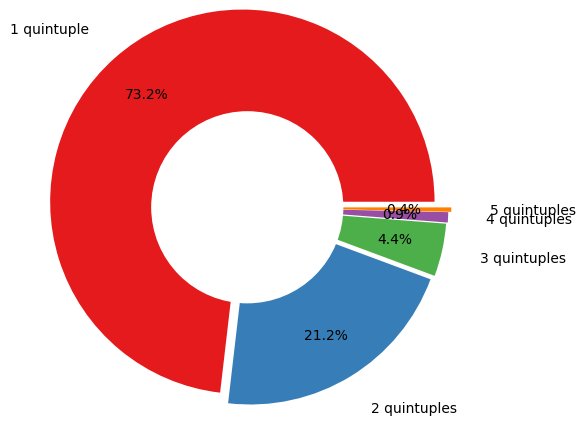

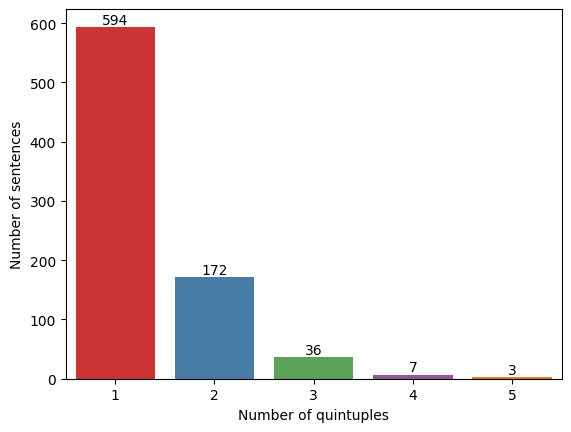

In [390]:
relate_sentences_to_quintuple_counter(TRAIN_DF, from_quins=1, stats_groups=6)

### 2. Analyzing sentences

Conclusions:
- Most of the sentences start with a capitalized word and end with a '.' (>2600).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences (**3359**) is about *4 times* larger than number of sentences with quin (**812**).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

⇒ Result: **1904** zero-quin, **812** quin-owner sentences left (ratio 2.3:1).

#### General stats (before modifying dataset)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- Critically imbalance between quin-owning and non-quin, especially in the range of 1-9 tokens.
- An abnormally large number of sentences have 1-8 tokens.

⇒ The need for identifying reasons & solutions, which aims to <u>make the uneven data more balance</u>.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': '“ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .', 'num_of_tokens': 82}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query)        sentence quintuples  num_of_tokens Has quintuple
11    alt : s22       None              3            No
12        des :       None              2            No
16    alt : s22       None              3            No
17        des :       None              2            No
27        des :       None              2            No
...         ...        ...            ...           ...
4144      des :       None              2            No
4149     

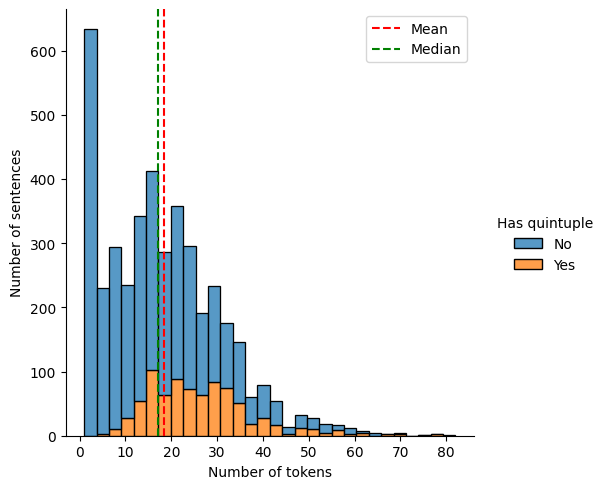

In [391]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {(df.query('num_of_tokens >= 1 & num_of_tokens <= 3 & quintuples.isna()'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

In [392]:
df.query('num_of_tokens >= 2 & num_of_tokens <= 3 & quintuples.isna()')

sentence quintuples  num_of_tokens Has quintuple
11    alt : s22       None              3            No
12        des :       None              2            No
16    alt : s22       None              3            No
17        des :       None              2            No
27        des :       None              2            No
...         ...        ...            ...           ...
4144      des :       None              2            No
4149      des :       None              2            No
4155      des :       None              2            No
4160      des :       None              2            No
4164      des :       None              2            No

[603 rows x 4 columns]

#### a. "Sentences" start with numbers
Conclusion: Most of the "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [393]:
# train_df = TRAIN_DF.copy()

print(f"Original size of training set: {len(train_df)}")

# Remove "sentences" start with numbers (\d*[(\\.[\d]*)]+)
train_df.drop(train_df[train_df.sentence.str.match("^\d{1,}(\W\d{1,}){0,} {1,}\W{1,}")].index.tolist(), inplace=True) # 105

print(f"Size of training set after modified: {len(train_df)}")

Original size of training set: 4171
Size of training set after modified: 4071


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``


In [394]:
# @title
""" Check if any sentence is duplicated """

# train_df = TRAIN_DF.copy()

print(f"Size of the training set before modified: {len(train_df)}")

dups = train_df[train_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Quin-owners: {len(dups_with_quin)}")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(train_df[train_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

# remove duplicates
# train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()]
remove_duplicates(train_df, mode="first-except-quin-owner", inplace=True)

print(f"Size of the training set after modified: {len(train_df)}")

Size of the training set before modified: 4071
Number of duplicates: 592
Quin-owners: 4
588 will be deleted
Size of the training set after modified: 3483


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/1
  - des: 499/216/24(23 unique)
  - alt: 500/332/1

  (always at the first position of the sentences)

  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt ?: )|(des ?: )|(title ?: )|(src ?: )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).
  - Sentences ending with '!' mostly don't have quin (except 1).

  => Propose deleting:
    - All '?' & 'title' sentences: 170 - 1
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset.
=> Continue removing duplicates by the recommended command above.

In [395]:
# @title
"""
In this section (and maybe others), I define a "special sentence" is a sentence
containing "alt", "des", "title" or "?", "src" (from test set).
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may have been filtered out (or not) before examining.
"""

# train_df = TRAIN_DF.copy()

questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
special_sentences = train_df[train_df.sentence.str.contains("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]
print()

## Questions & titles
# print(len(train_df[train_df.sentence.str.contains("title")]))
# print(len(train_df[train_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: Most of the sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove "Title :" in quin-owners & remove remaining questions and titles
titles = train_df[train_df.sentence.str.contains("^[Tt][Ii][Tt][Ll][Ee]")]
questions = questions_and_titles.drop(titles.index.tolist())

for i, s in titles.sentence.items():
  new_sent = regex.sub("(Title ?: ?)|(title ?:? ?)", "", s)
  train_df.sentence.replace(s, new_sent, inplace=True)

train_df.drop(titles[titles.quintuples.isna()].index.tolist(), inplace=True)
train_df.drop(questions.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")

tmp = len(train_df[train_df.sentence.duplicated()])

print(f"Dups before removing 'des : ' & 'alt : ': {tmp}")

# Substitute "(des : ?)|(alt : ?)" with "" and replace old strings with those in train_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des ?:? ?)|(alt ?:? ?)", "", special_sentences.iloc[i].sentence)
  train_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(train_df[train_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{train_df[train_df.sentence == new_sent]}\n")


print(f"Dups after removing 'des : ' & 'alt : ': {len(train_df[train_df.sentence.duplicated()])}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset ({len(train_df[train_df.sentence.duplicated()]) - tmp} increased)"""
)


# new_dups = train_df[train_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"\nTuple {i}:")
#   print(train_df[train_df.sentence.str.contains(new_dups.iloc[i].sentence)], end="\n")

# uncomment the code above to see all tuples
print("""
After observing all the duplicates (determined by the sentence column),
we can conclude that in each duplicate tuple, not all members are the same.
(Note that tuples of 'similar' members may be not included yet. For example:
"Điện thoại" vs "Điện thoại .")
"""
)



Sentences containing '?' and/or 'title : ' (140) and having quintuple: 1
=> Conclusion 3: Most of the sentences containing '?' and/or 'title : ' should be removed.



<ipython-input-395-1686491c7ec6>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
<ipython-input-395-1686491c7ec6>:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  special_sentences = train_df[train_df.sentence.str.contains("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]


Number of special sentences starting with 'des : ', 'alt : ': 549
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 25
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ': 4
Dups after removing 'des : ' & 'alt : ': 170

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (166 increased)

After observing all the duplicates (determined by the sentence column),
we can conclude that in each duplicate tuple, not all members are the same.
(Note that tuples of 'similar' members may be not included yet. For example:
"Điện thoại" vs "Điện thoại .")



In [396]:
# Remove duplicates
print(f"Size of the training set before modified: {len(train_df)}")
remove_duplicates(train_df, mode="all-non-quin", inplace=True)
print(f"Size of training set after modified: {len(train_df)}")

Size of the training set before modified: 3344
303 will be deleted
Size of training set after modified: 3041


#### d. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.

**Conclusion 6**: Most of "short" sentences does not contain quintuple. Specifically, we can remove all sentences with 0-3 tokens and consider to remove sentences with 4-7 tokens (but the sentences with quintuple should be kept).


- Sentences with ...
(Pattern: `<total of sentences> - <sentences contain quintuple>`)
  - 0-3 tokens: 163 - 0
  - 4 tokens: 54 - 1
  - 5 tokens: 51 - 2
  - 6 tokens: 55 - 3
  - 7 tokens: 78 - 3
  - 8 tokens: 74 - 7

    ...

In [397]:
""" Examine sizes of the training sentences """
MINIMUM_NUM_OF_TOKENS = 7
# train_df = TRAIN_DF.copy()
print(f"Size of training set before modified: {len(train_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = train_df.loc[[item[0] for item in train_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")
  print(f"=> Delete: {len(short_sentences) - len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  train_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"training size: {len(train_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of training set after modified: {len(train_df)}\n")

Size of training set before modified: 3041

Given minimum number of tokens is 0.
Number of short sentences: 0
Number of short sentences with quin: 0
=> Delete: 0

Given minimum number of tokens is 1.
Number of short sentences: 34
Number of short sentences with quin: 0
=> Delete: 34

Given minimum number of tokens is 2.
Number of short sentences: 45
Number of short sentences with quin: 0
=> Delete: 45

Given minimum number of tokens is 3.
Number of short sentences: 53
Number of short sentences with quin: 0
=> Delete: 53

Given minimum number of tokens is 4.
Number of short sentences: 47
Number of short sentences with quin: 1
=> Delete: 46

Given minimum number of tokens is 5.
Number of short sentences: 45
Number of short sentences with quin: 2
=> Delete: 43

Given minimum number of tokens is 6.
Number of short sentences: 49
Number of short sentences with quin: 3
=> Delete: 46

Given minimum number of tokens is 7.
Number of short sentences: 61
Number of short sentences with quin: 3
=> De

#### e. Others


In [398]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = flattened_train_df.drop(flattened_train_df[flattened_train_df.sentence.str.match("^\d{1,}(\W\d{1,}){0,} {1,}\W{1,}")].index.tolist())
# df = flattened_train_df

# print(len(flattened_train_df.sentence.unique()))
query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
# ending_dots = df[df.sentence.str.contains(r"")]#.query("label.isna()")
# ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())

<ipython-input-398-f97038893c00>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")


sentence  \
314   Xiaomi Mi 11 sở hữu màn hình nền AMOLED có thể...   
401   Một số tính năng đặc biệt cũng có ở Galaxy A73...   
483       Title : Đánh giá iPhone SE 2022 : Khoan . . .   
620   Tỷ lệ màn hình chính của Samsung Galaxy ...   
663   Trong khi Samsung Z Fold 4 được cung cấp viê...   
687   Khi đánh giá Samsung Galaxy S22 Ultra 5G và Ga...   
799   Bộ 4 camera với nhiều tính năng hiện đại...   
889   Giúp người dùng thoải mái lướt web , chơ...   
966   Nếu bạn thích trải nghiệm một chiếc điê...   
1045  Điểm đáng cân nhắc nhất khi lựa chọn Galaxy A5...   
1373  Các điện thoại giá rẻ như Google Pixel 5A...   
1530  Trong khi iPhone 12 Pro Max bắt đầu từ mức giá...   
1565  Google Pixel 6 Pro sở hữu 3 camera sau với ống...   
1566  Như đã nói , iPhone 13 Pro được trang bị cụm c...   
1607  Không những vậy , điện thoại cũng được tr...   
1733  Mặt khác , bạn có thể nhận được dung lượng lưu...   
1734  Mặt khác , bạn có thể nhận được dung lượng lưu...   
1746  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
1747  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
1748  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
1890  Galaxy A11 chạy hệ điều hành Android 10 với tù...   
1982  Galaxy A11 trang bị viên pin Li-Po 4.000 mAh ....   
2190  Không chỉ có camera xịn xò , vô số các t...   
2221  Nếu bạn là học sinh - sinh viên hay những...   
2597  Phải nói năm nay Samsung chơi lớn trên những c...   
2766  Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
2767  Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
2784  Cả ba smartphone này đều sở hữu viên pin có du...   
2785  Cả ba smartphone này đều sở hữu viên pin có du...   
2786  Cả ba smartphone này đều sở hữu viên pin có du...   
2802  Máy có thiết kế nguyên khối trẻ trung , đi kèm...   
2810  Thiết bị sở hữu màn hình Super AMOLED kích thư...   
2829  Ngoài ra , tần số quét của hai màn hình là 120...   
2837  Hai bộ camera này chính là chân ái của người d...   
2919  Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
2920  Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
2924  Trên Vivo Y21 có camera kép bao gồm camera chí...   
2929  Samsung Galaxy A03s và Vivo Y21 đều mang trên ...   
2933  Ưu điểm thường thấy trên smartphone giá rẻ là ...   
2941  Riêng cá nhân mình , thì mình sẽ nghiêng về Ga...   
3016  So sánh một chút với chiếc Realme 6 hoặc Realm...   
3052  Trước khi nói về khả năng chơi game , mình thấ...   
3152  Nó đi kèm sạc nhanh 25W , vẫn là nhanh nhưng đ...   
3226  Galaxy S20 Ultra đã chính thức được Samsung gi...   
3439  Camera hỗ trợ những tính năng nổi bật như chụp...   
3478  Dòng điện thoại này được hỗ trợ thêm những tín...   
3507  Thông qua những so sánh ở trên đã chỉ ra 2 chi...   
3938  Realme 6 Pro có màn hình IPS , nhưng nó có tốc...   
4068  iPhone 14 được nhà sản xuất sử dụng chipset A1...   
4307  Xét về pin giữa A23 và A32 về dung lượng pin t...   
4308  Xét về pin giữa A23 và A32 về dung lượng pin t...   

                     subject  \
314        smartphone Xiaomi   
401                      NaN   
483                      NaN   
620                      NaN   
663                      NaN   
687                      NaN   
799                      NaN   
889    kích thước 7,6 inch   
966                      NaN   
1045                     NaN   
1373                     NaN   
1530                     NaN   
1565                     NaN   
1566           iPhone 13 Pro   
1607            điện thoại   
1733     Redmi Note 11 Pro +   
1734      hai smartphone này   
1746   Samsung Galaxy M52 5G   
1747                      nó   
1748     Redmi Note 11 Pro +   
1890            hệ điều hành   
1982              Galaxy A11   
2190                     NaN   
2221                     NaN   
2597                     NaN   
2766           Redmi Note 11   
2767                      nó   
2784   Samsung Galaxy M32 5G   
2785                      nó   
2786              

#### General stats (after modifying dataset)

In [430]:
print(f"{len(train_df[train_df.quintuples.isna()])} / {len(train_df[train_df.quintuples.notna()])}")

1904 / 812


##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': '“ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .', 'num_of_tokens': 82}
Sentence with smallest number of tokens:
{'sentence': 'Màn hình tương đương', 'num_of_tokens': 4}

       num_of_tokens
count    2716.000000
mean       24.248527
std        11.169104
min         4.000000
25%        16.000000
50%        22.000000
75%        30.000000
max        82.000000


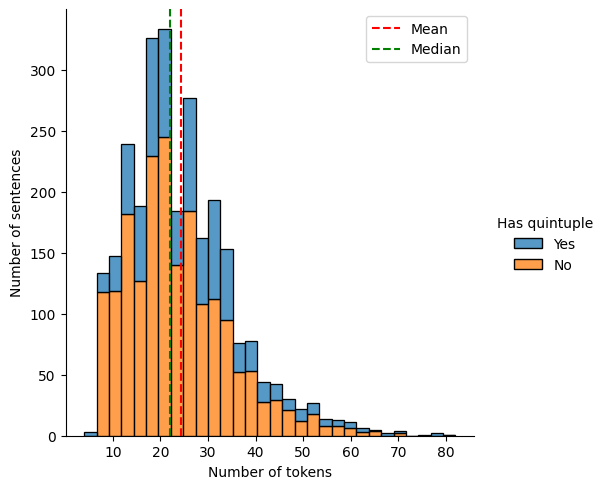

In [400]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

# print(f"(Test query) {(df.query('num_of_tokens >= 8 & num_of_tokens <= 8'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

### 3. Analyzing quintuple fields

Note: may need to validate word's indexes in quintuples

#### a. subject

###### General reviews

- A subject can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro"...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới"...
  - a phrase showing (owning) relationship between 2 nouns: "điện thoại đắt tiền hơn của Apple", "Các bức ảnh chụp với S20", "Màn hình của Redmi Note 11 Pro +", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 3 chiếc máy", ...
  - more complicated form: "các cổng kết nối cùng nút bấm", "Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa", "Chip A15 Bionic cung cấp hiệu năng khủng cho iPhone 13", ...
- There're some presences of miss spelling ("ấn tượn" -> "ấn tượng"), lack of spaces ("SEmới) ... This typing errors are trivial & quite rare.

  ⇒ should be corrected.

- Length: 1-16,
  - The distribution is mainly in range 1-6.
  - Subjects with length 9-16 rarely exist.
- Presences of non-word characters ('+', '-', ',', '.', '/', etc):

  ...

- Total of blank subjects / All quintuples: 128/1089
- Total of non-blank unique subjects / Non-blank subjects: 427/961

Longest:
  {'subject': 'Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa', 'tokens': ['Màn', 'hình', 'đục', 'lỗ', 'không', 'khống', 'chế', 'ở', 'góc', 'màn', 'hình', 'mà', 'lại', 'là', 'chính', 'giữa'], 'length': 16}
Shortest:
  {'subject': 'nó', 'tokens': ['nó'], 'length': 1}


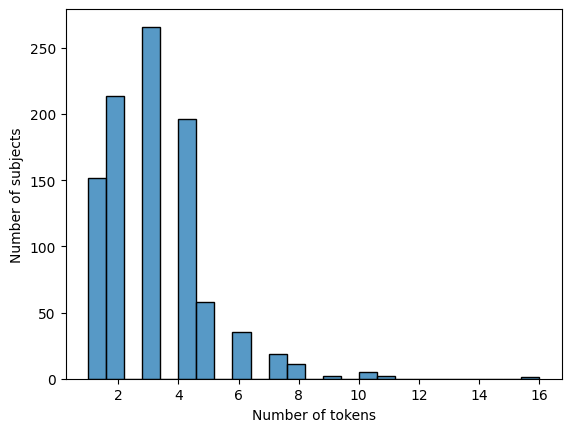

In [401]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.subject.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank subjects / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

df = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)]

subjects = df.subject
unique_subjects = df.subject.unique().tolist()

print(f"- Total of non-blank unique subjects / Non-blank subjects: {len(unique_subjects)}/{len(subjects)}")
print()

tokenized_subjects = []

for s in subjects:
  tokens = nltk.word_tokenize(s)
  tokenized_subjects.append({
      "subject": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_subject = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_subjects)
shortest_subject = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_subjects)

print(f"Longest:\n  {longest_subject}")
print(f"Shortest:\n  {shortest_subject}")

subjects_lengths: list[int] = [s.get("length") for s in tokenized_subjects]

sbn.histplot(pd.Series(subjects_lengths), bins=25)
plt.xlabel("Number of tokens")
plt.ylabel("Number of subjects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in subjects. => most of datasets come from 'electronic device reviews', especially in topics about 'cellphone', 'camera'.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" always goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "chiếc" - 29,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [402]:
nonblank_values = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)].subject

In [403]:
""" Bag-of-Words """
subject_bow: dict[str, int] = make_BoW(nonblank_values)
print(subject_bow)
print(f"Size of BoW: {len(subject_bow)}")

{'galaxy': 234, 'ultra': 127, 'samsung': 125, 'pro': 103, 'iphone': 100, 'hai': 89, 'cả': 87, 'điện': 72, 'thoại': 72, 's23': 53, '2': 44, 'này': 43, 'máy': 42, 'nó': 42, 's22': 35, 'note': 35, '11': 35, 'của': 34, '5g': 34, 'xiaomi': 33, '13': 32, 'max': 32, 'z': 29, 'chiếc': 29, 'dòng': 28, 'camera': 27, 's21': 27, 'oppo': 23, 'hình': 23, 'plus': 22, '12': 20, '+': 19, 'điện': 19, 'thoại': 19, 's20': 19, 'flip': 18, 'find': 18, 'smartphone': 18, 'trên': 17, '14': 17, 'redmi': 17, 'màn': 16, 'mẫu': 16, 'snapdragon': 16, 'đây': 16, 'a51': 16, 'ảnh': 15, 'pixel': 15, 'a53': 13, 'apple': 13, 'a73': 12, 'cả': 12, '8': 12, 'các': 12, 'realme': 12, '20': 12, 'mới': 11, 'sản': 11, 'phẩm': 11, 'n2': 11, 'mi': 11, 'se': 11, '7': 11, 's10': 11, 'm51': 11, '4': 10, 'chip': 10, 'a23': 10, 'thiết': 10, 'phiên': 10, 'bản': 10, 'a13': 10, 'a32': 10, 'a52s': 10, 'với': 9, 'thiết': 9, 'bị': 9, 'fold2': 9, 'rog': 9, 'phone': 9, 'flagship': 8, 'bị': 8, 'fold': 8, 'bộ': 8, 'di': 8, 'động': 8, 's-pen

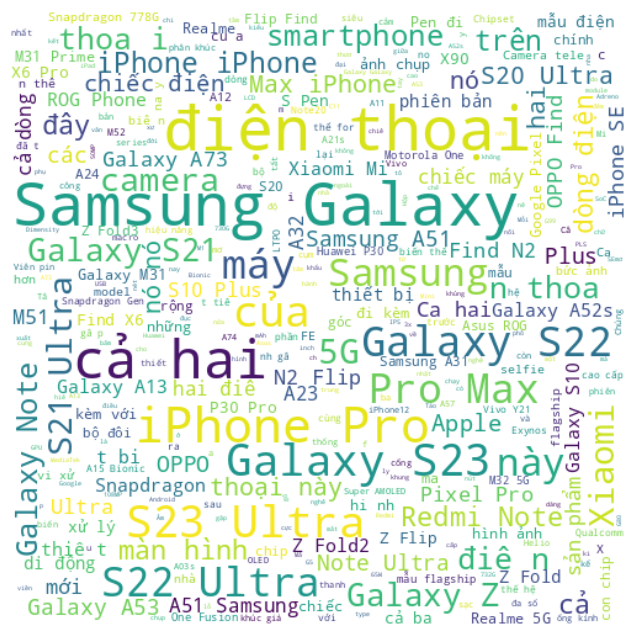

In [404]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [405]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ -
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
filt = [s for s in nonblank_values if re.match(".{0,}chiếc.{0,}", s.lower())]
len(filt)

29

#### b. object

###### General reviews

- An object can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An object may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank objects / All quintuples: 468/1089
- Total non-blank unique object / Non-blank objects: 355/621
Longest:
  {'object': 'các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi', 'tokens': ['các', 'màn', 'hình', 'có', 'tốc', 'độ', 'làm', 'mới', '90', 'Hz', 'hay', '120', 'Hz', 'của', 'Realme', 'hoặc', 'Xiaomi'], 'length': 17}
Shortest:
  {'object': 'A23', 'tokens': ['A23'], 'length': 1}



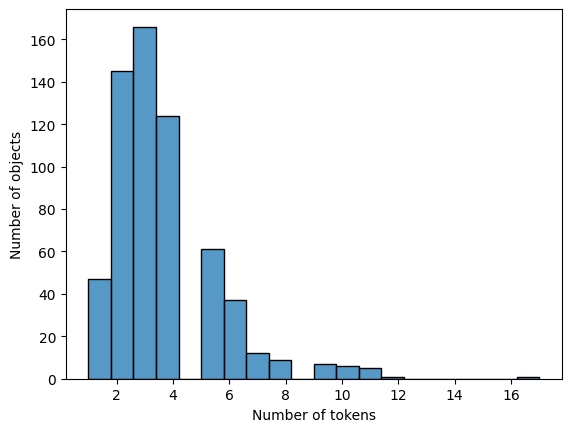

In [406]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.object.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank objects / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)]

objects = df.object
unique_objects = objects.unique().tolist()

print(f"- Total non-blank unique object / Non-blank objects: {len(unique_objects)}/{len(objects)}")

tokenized_objects = []

for s in objects:
  tokens = nltk.word_tokenize(s)
  tokenized_objects.append({
      "object": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_object = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_objects)
shortest_object = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_objects)

print(f"Longest:\n  {longest_object}")
print(f"Shortest:\n  {shortest_object}\n")

objects_lengths: list[int] = [s.get("length") for s in tokenized_objects]

sbn.histplot(pd.Series(objects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of objects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại", "cả" ... are some of the most popular words in objects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "thế hệ", "tiền nhiệm" ... All of these are Vietnamese compound words; member words always stand together.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [407]:
# Execute this first
nonblank_values = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)].object

In [408]:
""" Bag-of-Words """
object_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in object_bow.items() if i[1] < 3])
print(f"Size of BoW: {len(object_bow)}")

[('n2', 2), ('bình', 2), (',', 2), ('hay', 2), ('trung', 2), ('9', 2), ('con', 2), ('đại', 2), ('diện', 2), ('m1', 2), ('ipad', 2), ('``', 2), ('khả', 2), ('năng', 2), ('đêm', 2), ('hệ', 2), ('inch', 2), ('bản', 2), ('ghz', 2), ('điểm', 2), ('số', 2), ('a16', 2), ('người', 2), ('mình', 2), ('tất', 2), ('hiện', 2), ('chipset', 2), ('a14', 2), ('5', 2), ('20', 2), ('micro-usb', 2), ('ips', 2), ('hàng', 2), ('mặt', 2), ('dòng', 2), ('chúng', 2), ('mới', 2), ('đó', 2), ('a57', 2), ('thông', 2), ('mediatek', 2), ('a74', 2), ('mini', 2), ('m32', 2), ('a52s', 2), ('a03s', 2), ('vivo', 2), ('adreno', 2), ('hz', 2), ('s22', 2), ('hùng', 2), ('mạnh', 2), ('ống', 2), ('kính', 2), ('full-frame', 2), ('f', 2), ('xs', 2), ('ngày', 2), ('hôm', 2), ('kế', 2), ('9000', 2), ('s10e', 2), ('phụ', 1), ('a33', 1), ('thậm', 1), ('chí', 1), ('là', 1), ('845', 1), ('mọi', 1), ('sử', 1), ('dụng', 1), ('thuật', 1), ('toán', 1), ('ai', 1), ('chiếc', 1), ('máy', 1), ('tính', 1), ('bảng', 1), ('quyển', 1)

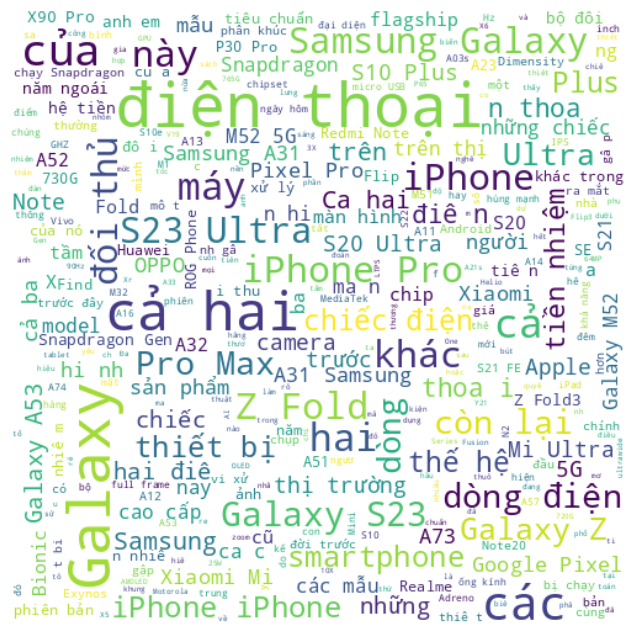

In [409]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [410]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}thoại.{0,}", s.lower())]
filt

['Cả hai điện thoại',
 'những chiếc điện thoại bình thường',
 'những chiếc điện thoại bình thường',
 'chiếc điện thoại gập còn lại',
 'chiếc điện thoại gập còn lại',
 '2 mẫu điện thoại',
 'một chiếc điện thoại tầm trung',
 'cả hai điện thoại',
 'Cả 2 chiếc điện thoại',
 'Cả 2 chiếc điện thoại',
 'cả 2 chiếc điện thoại này',
 'cả 2 chiếc điện thoại này',
 'Cả 2 điện thoại',
 'bộ đôi điện thoại',
 'bộ đôi điện thoại',
 'bộ đôi điện thoại',
 'camera trước của điện thoại màn hình gập',
 'chiếc điện thoại nào trên thị trường',
 'Cả hai điện thoại',
 'Cả hai điện thoại',
 'các mẫu điện thoại tầm trung giá rẻ khác của Samsung',
 'những điện thoại cao cấp hơn',
 'những điện thoại hàng đầu của Samsung năm nay',
 'những điện thoại hàng đầu của Samsung năm nay',
 'các mẫu điện thoại mới ra mắt của nhà Samsung',
 'các điện thoại khác',
 'các chiếc điện thoại trên',
 'các điện thoại khác trong phân khúc',
 'hai điện thoại còn lại',
 'hai điện thoại còn lại',
 'hai điện thoại còn lại',
 'các mẫu 

#### c. aspect

###### General reviews *(not modified yet)*

- An aspect can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An aspect may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank aspects / All quintuples: 154/1089
- Total non-blank unique aspect / Non-blank aspects: 564/935
Longest:
  {'aspect': 'khả năng tái tạo màu sắc chính xác và ổn định trong hầu hết mọi điều kiện', 'tokens': ['khả', 'năng', 'tái', 'tạo', 'màu', 'sắc', 'chính', 'xác', 'và', 'ổn', 'định', 'trong', 'hầu', 'hết', 'mọi', 'điều', 'kiện'], 'length': 17}
Shortest:
  {'aspect': 'camera', 'tokens': ['camera'], 'length': 1}



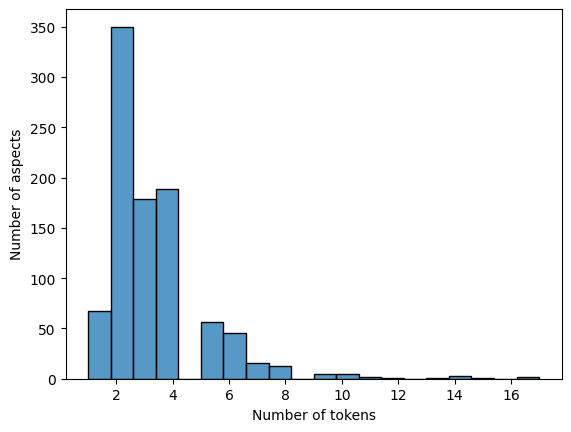

In [411]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.aspect.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank aspects / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)]

aspects = df.aspect
unique_aspects = aspects.unique().tolist()

print(f"- Total non-blank unique aspect / Non-blank aspects: {len(unique_aspects)}/{len(df)}")

tokenized_aspects = []

for s in aspects:
  tokens = nltk.word_tokenize(s)
  tokenized_aspects.append({
      "aspect": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_aspect = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_aspects)
shortest_aspect = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_aspects)

print(f"Longest:\n  {longest_aspect}")
print(f"Shortest:\n  {shortest_aspect}\n")

aspects_lengths: list[int] = [s.get("length") for s in tokenized_aspects]

sbn.histplot(pd.Series(aspects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of aspects")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in aspects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "tiền nhiệm", "thế hệ", "thị trường" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [412]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

nonblank_values = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)].aspect

In [413]:
""" Bag-of-Words """
aspect_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in aspect_bow.items() if i[1] > 6])
print(f"Size of BoW: {len(aspect_bow)}")

[('hình', 118), ('năng', 94), ('lượng', 80), ('độ', 76), ('màn', 75), ('ảnh', 73), ('camera', 69), ('pin', 63), ('khả', 45), ('chụp', 41), ('chất', 39), ('hiệu', 36), ('kế', 35), ('thiết', 34), ('sạc', 32), ('số', 30), ('mức', 27), ('các', 25), ('kích', 24), ('bộ', 24), ('dung', 24), ('giá', 24), ('thước', 23), ('phân', 22), ('giải', 22), ('phần', 22), ('cảm', 20), ('mặt', 20), ('màu', 19), ('biến', 18), ('tiết', 18), ('thời', 18), ('sáng', 18), ('lý', 17), ('thông', 17), ('tốc', 16), ('chính', 16), ('xử', 16), ('hiển', 16), ('thị', 16), ('điểm', 16), ('hình', 16), ('sắc', 15), ('sau', 14), ('đa', 14), ('không', 14), ('chi', 13), ('động', 12), ('công', 12), ('chip', 12), ('và', 12), ('trong', 12), ('máy', 11), ('suất', 11), ('tính', 11), ('cấu', 11), ('lượng', 11), ('trước', 11), ('cụm', 11), ('mới', 11), ('này', 10), ('kính', 10), ('làm', 10), ('màn', 10), ('tối', 10), ('selfie', 10), ('những', 10), ('định', 10), ('cứng', 10), ('dây', 10), ('nhanh', 10), ('quay', 9), ('nghệ', 9), (

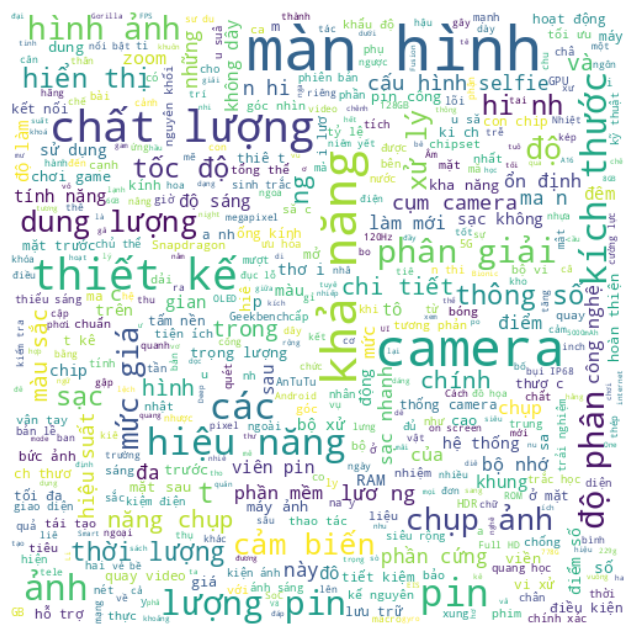

In [414]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=450, background_color="white")

In [415]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}hệ.{0,}", s.lower())]
filt

['công nghệ 5G',
 'công nghệ sạc',
 'công nghệ',
 'hệ thống camera',
 'hệ thống camera',
 'công nghệ tấm nền OLED mới nhất của Samsung',
 'hệ thống camera',
 'hệ điều hành iOS',
 'hệ thông camera',
 'hệ thống camera',
 'hệ thống camera',
 'hệ thống máy ảnh',
 'công nghệ sạc nhanh tối đa 25 W',
 'công nghệ pin',
 'công nghệ màn hình LTPO',
 'bộ phận tạo nên hệ thống hình ảnh đồng bộ hoá',
 'công nghệ sạc',
 'công nghệ sạc nhanh']

#### d. predicate

###### General reviews *(not modified yet)*

- A predicate can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- A predicate may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank predicates / All quintuples: 0/1089
- Total non-blank unique predicate / Non-blank predicates: 630/1089
Longest: 19 (1 results). Example:
  {'predicate': 'đều được sử dụng chip Snapdragon 8 Gen 2 mới nhất của Qualcomm với các lõi được ép xung', 'length': 19, 'sentence': 'Cấu hình Samsung S23 + và S23 Ultra đều được sử dụng chip Snapdragon 8 Gen 2 mới nhất của Qualcomm với các lõi được ép xung .'}
Shortest: 1 (21 results). Example:
  {'predicate': 'đều', 'length': 1, 'sentence': 'Cả Samsung Galaxy A73 và S21 FE đều là những chiếc điện thoại hỗ trợ đầy đủ các tính năng và thực hiện tốt các tác vụ hằng ngày .'}



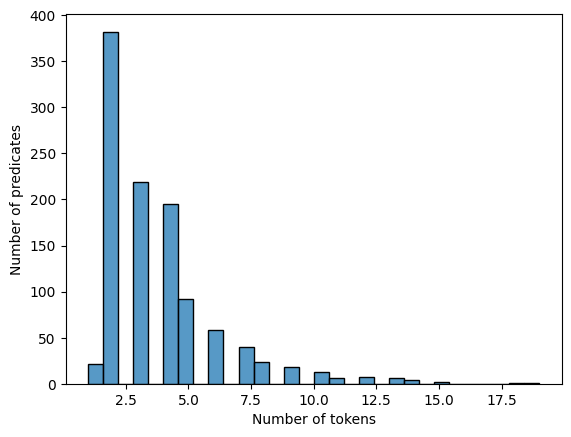

In [416]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.predicate.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank predicates / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)]

unique_predicates = df.predicate.unique().tolist()

print(f"- Total non-blank unique predicate / Non-blank predicates: {len(unique_predicates)}/{len(df)}")

tokenized_predicates = []

for i, p in df.predicate.items():
  tokens = nltk.word_tokenize(p)
  tokenized_predicates.append({
      "predicate": p,
      "length": len(tokens),
      "sentence": df.loc[i].sentence
  })

longest_predicate = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_predicates)
shortest_predicate = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_predicates)

print(f"Longest: {longest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == longest_predicate.get('length')])} results). Example:\n  {longest_predicate}")
print(f"Shortest: {shortest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == shortest_predicate.get('length')])} results). Example:\n  {shortest_predicate}\n")

# Show sentences with a specific number of predicate length
# [print(p) for p in tokenized_predicates if p.get('length') == 1]

predicates_lengths: list[int] = [s.get("length") for s in tokenized_predicates]

sbn.histplot(pd.Series(predicates_lengths), bins=30)
plt.xlabel("Number of tokens")
plt.ylabel("Number of predicates")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "so với", "so sánh", "hơn", "chút", "tốt", "nhất", "không" ... are some of the most popular words in predicates.

- Some tuples of words usually stand together, for example:
  - "một chút", "mạnh mẽ", "", "chi tiết", "tiết kiệm", "thế hệ", "thị trường", "xử lý", "tương đồng", "tương tự", "màu sắc", "sắc nét", "sử dụng", "hiện nay", "hiện tại", ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25, "cả" - 2

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [417]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

nonblank_values = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)].predicate

In [418]:
""" Bag-of-Words """
predicate_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in predicate_bow.items() if i[1] > 3])
print(f"Size of BoW: {len(predicate_bow)}") # largest in the 4 fields of quin

[('hơn', 501), ('tốt', 117), ('đều', 109), ('nhất', 105), ('có', 89), ('không', 82), ('cao', 74), ('nhiều', 71), ('như', 47), ('khác', 45), ('tương', 44), ('được', 44), ('vượt', 43), ('một', 39), ('biệt', 38), ('trội', 38), ('lớn', 36), ('cấp', 36), ('nay', 35), ('hiện', 31), ('mạnh', 31), ('nhau', 30), ('sự', 30), ('chút', 30), ('thế', 28), ('rất', 26), ('nhanh', 25), ('nhỉnh', 25), ('và', 25), ('giống', 23), ('bị', 23), ('trên', 21), ('trong', 21), ('thấp', 21), ('khá', 20), ('ngang', 19), ('chi', 19), ('kém', 19), ('là', 19), ('trang', 18), ('đều', 18), ('mẽ', 18), ('với', 18), ('của', 17), ('sở', 17), ('gần', 17), ('tiết', 17), ('nâng', 17), ('nhỏ', 16), ('so', 16), ('cải', 15), ('hữu', 15), ('thể', 15), ('đáng', 15), ('đương', 15), ('lượng', 15), ('chênh', 14), ('nhẹ', 13), ('thị', 13), ('phân', 13), ('về', 13), ('đồng', 13), ('tiến', 13), ('sáng', 12), ('lợi', 12), ('rẻ', 12), ('dụng', 12), ('được', 12), ('cùng', 12), ('giới', 11), ('quá', 11), ('bằng', 11), ('trường', 11), ('s

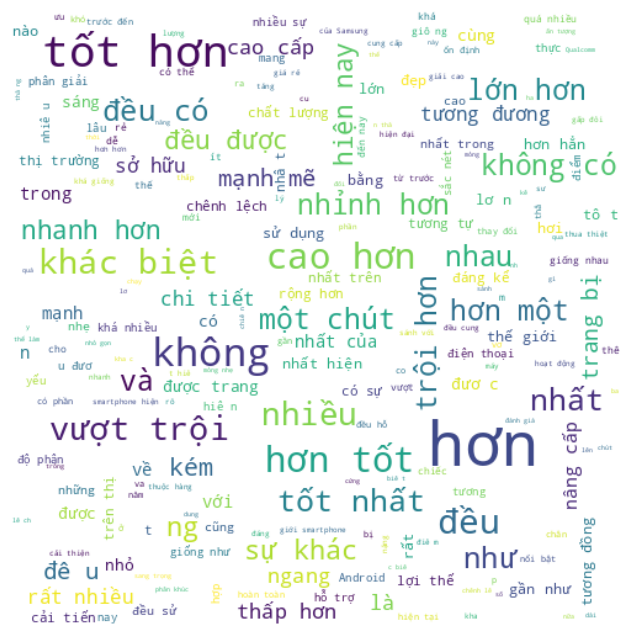

In [419]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist())

In [420]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: khác biệt, không có,...

# filt = [s for s in nonblank_values if re.match(".{0,}hiện.{0,}", s.lower())]

# Use some keywords of the DIF predicates to query predicates of other labels
print("Predicates of 'DIF':")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}.{0,}", str(v).lower())]].query("label == 'DIF'").predicate.unique())

print("\nPredicates of EQL:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'").predicate.unique())

print("\nPredicates of COM:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label.str.contains('COM', na=False)").predicate.unique())

# Query original sentences
# flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'")
# filt

Predicates of 'DIF':
['không có nhiều sự khác biệt' 'khác nhau' 'khác biệt'
 'sự khác biệt rõ ràng nhất' 'không có' 'khác biệt' 'có một khoảng cách'
 'Khác biệt'
 'hiếm có chiếc điện thoại nào trên thị trường có thể làm được'
 'một trong những điểm khác biệt dễ thấy nhất' 'sự khác biệt đáng kể'
 'Khác' 'có sự chênh lệch khá lớn' 'ngược lại'
 'khác biệt dễ nhận thấy' 'không hoàn toàn ngang bằng'
 'lột xác hoàn toàn' 'không bị ngả sang tone vàng như'
 'không bị bệt hay mất chi tiết như' 'không hề có một chiếc tai thỏ nào'
 'thay đổi' 'không có tính năng tương tự' 'Không sở hữu sự tương đồng'
 'Điểm khác biệt' 'thiếu' 'hơi lạ' 'hơi dịch lên phía trên một chút'
 'chênh lệch rõ ràng' 'khác biệt rõ ràng' 'không giống như'
 'sự khác nhau' 'nhiều sự khác biệt hơn thế' 'sự thay đổi đáng kể'
 'điểm khác biệt lớn nhất' 'không còn như xưa' 'không đều'
 'không có khả năng sạc nhanh vượt trội như' 'có sự khác biệt'
 'rất khác nhau' 'khác biệt đáng kể' 'Điểm khác biệt lớn nhất'
 'khô

#### e. label

Do labels relate to the existences of remaining fields?

List some following information of the 4 remaining fields for each label type:
- predicate: most popular words (may render cloudword)
- frequencies of existences of the 3 fields (subject, object, aspect)
- subject & object: most popular (compound) words (?)


**Idea**:

Due to the fact that:
- predicate always exists in a quintuple
- subject, object & aspect may be absent concurrently

we can scan/identify "predicate candidates" to divide sentences into 3 groups. In each of groups, they will be continously classified into 1 of 9 labels (NON included) by resolving *sub-problems*.
- Group 1: Equal-comparative (ECOM); including EQL & DIF
- Group 2: Comparative (COM); including
  - COM-: negative
  - COM: neutral
  - COM+: positive
- Group 3: Superlative(SUP); including
  - SUP-: negative
  - SUP: neutral
  - SUP+: positive
- Group 4: Non-comparative (NON)

After having 4 groups:
- in the group 1, we'll need to resolve the *binary classification* problem.
- in the group 2 & 3, we'll need to resolve the *Sentimental Classification* problem.


others problems:
- what if 1 sentence provides 2 quintuples that possess the same predicate (subjects/objects/aspect may be diff)? Can the labels be diff in this case?


##### Init & creating helper functions

In [421]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)
####

blank_counter = len(flattened_df[flattened_df.label.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank labels / All quintuples: {blank_counter}/{TOTAL_TRAIN_QUINTUPLES}")

labels = flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique().tolist()

groups = ["NON", "COM", "SUP"]
ecom_df = flattened_df[flattened_df.label.str.match("(DIF)|(EQL)", na=False)]
com_df = flattened_df[flattened_df.label.str.contains("COM", na=False)]
sup_df = flattened_df[flattened_df.label.str.contains("SUP", na=False)]

- Total of blank labels / All quintuples: 0/1089


In [422]:
def calc_BoW(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect", "predicate"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"

  return make_BoW(df[df.label == label][field])

def calc_frequency(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"


  df_l = df[df.label == label]
  df_f = df_l[df_l[field].str.contains("^.{1,}$", na=False)]

  return len(df_f)

# Test
# calc_frequency("subject", "SUP")

##### i. Counting quintuples & sentences on each type of label
Main function: `relate_labels_with_others(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:
(group 'SUP-' and 'SUP')
        label  num_of_data_points  num_of_sentences
0        COM+                 500               371
1         EQL                 287               249
2        SUP+                 107                87
3        COM-                 107                86
4         DIF                  58                52
5         COM                  21                19
6  SUP- & SUP                   9                 8



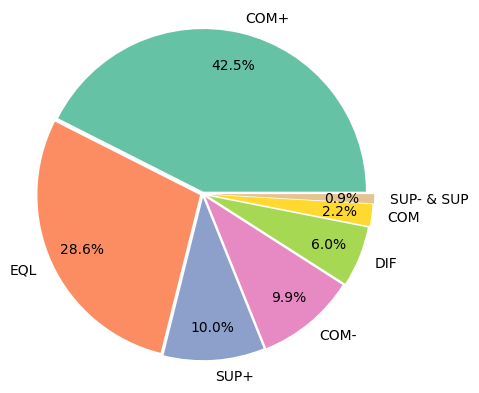

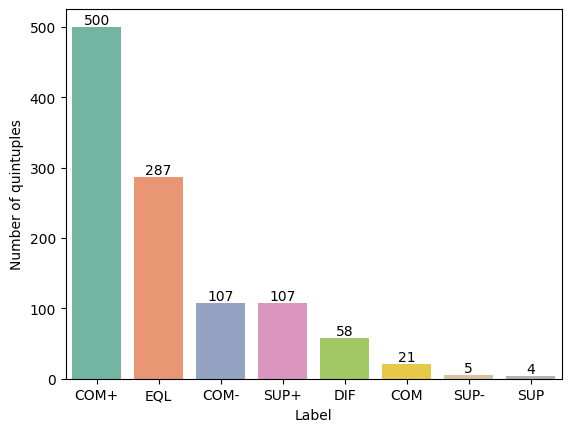

In [423]:
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)

def relate_labels_with_others(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "label": label,
      "num_of_data_points": len(flattened_df[flattened_df.label == label]),
      "num_of_sentences": len(flattened_df[flattened_df.label == label].sentence.unique())

  } for label in list(flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique())]

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:")
  # print(statistic)
  # print()

  ## Group SUP- & SUP (each has 4 sentences) before rendering
  x = statistic.set_index("label").drop(["SUP-", "SUP"]).reset_index()
  minor_data = statistic[statistic.label.str.match("^(SUP-)|(SUP)$", na=False)]#.reset_index()
  minor_data_grouping_point = pd.DataFrame([{
      "label": "SUP- & SUP",
      "num_of_data_points": reduce(lambda acc, val: acc + val, minor_data["num_of_data_points"].tolist()),
      "num_of_sentences": reduce(lambda acc, val: acc + val, minor_data["num_of_sentences"].tolist())
  }])

  x = pd.concat([x, minor_data_grouping_point], ignore_index=True)
  print(f"(group 'SUP-' and 'SUP')\n{x}\n")

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06]

  plt.pie(x["num_of_sentences"], labels=x.label.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1.1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  # plt.title('Số lượng data point trên từng label')
  plt.show()
  print()

  plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
                      order=list(flattened_df.value_counts("label").index),
                      palette=color_pallete)
  plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  plot.bar_label(plot.containers[0])

  plt.show()

relate_labels_with_others(flattened_df)

##### ii. Counting quintuples & sentences in each group
Main function: `relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each group:
                   group  num_of_data_points  num_of_sentences
1      COM (Comparative)                 628               459
2  NON (Non-comparative)                 345               294
0      SUP (Superlative)                 116                94



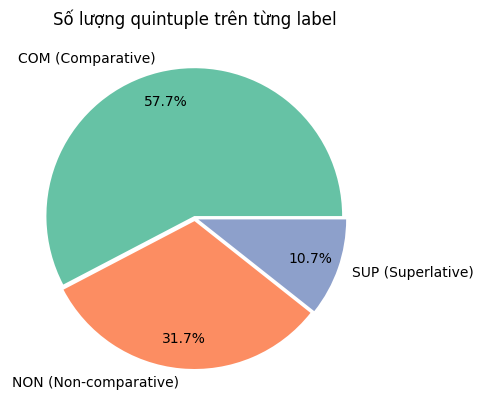

In [424]:
flattened_df = pd.DataFrame(FLAT_TRAIN_DATASET)

def relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "group": "SUP (Superlative)",
      "num_of_data_points": len(sup_df),
      "num_of_sentences": len(sup_df.sentence.unique())
  }]

  statistic.append({
      "group": "COM (Comparative)",
      "num_of_data_points": len(com_df),
      "num_of_sentences": len(com_df.sentence.unique())

  })

  statistic.append({
      "group": "NON (Non-comparative)",
      "num_of_data_points": len(ecom_df),
      "num_of_sentences": len(ecom_df.sentence.unique())
  })

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each group:")
  print(statistic)
  print()

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025]

  plt.pie(statistic["num_of_data_points"], labels=statistic.group.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  plt.title('Số lượng quintuple trên từng label')
  plt.show()
  print()

  # plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
  #                     order=list(flattened_df.value_counts("label").index),
  #                     palette=color_pallete)
  # plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  # plot.bar_label(plot.containers[0])

  # plt.show()

relate_groups_with_quin_and_sent(flattened_df)

##### iii. Relate labels to the remaining quintuple fields

**Labels vs predicates**
(Common characteristics)
- Predicates in general show key opinions of authors/reviewers about the comparisons between 2 products/product lines...
- In predicates, adverbs along with adjectives takes up most of the words. Specifically, some of them are:
  - Adverbs of degree: hơi, rất, khá, nhất
  - Adverbs of manner: tốt
  - Adjectives (may be specific to context): mạnh mẽ, khác biệt

**Labels vs subjects**

**Labels vs objects**

**Labels vs aspects**


###### Non-comparative group

- "EQL" predicates (287q):
  - Keywords:
    - Adj:
      - không có .+ khác biệt
      - không có .+ chênh lệch
      - Tương tự/tương đồng
      - Ngang/giống/bằng nhau
    - Adverb of degree: (không) đáng kể, lớn, nhiều
      ...

- "DIF" predicates (58q):
  - Keywords:
    - Adj: khác biệt, khác nhau, không bằng (như)
    - Adv of degrees: rõ ràng,
    
      ...

- There're ambiguities in classifying label based on predicates.
For example, the sentences with predicate "không có khác biệt" (or similar ones) are mostly considered as "EQL", but sometimes are sorted into "DIF".

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|4437|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||bộ vi xử lý|tương tự nhau|EQL|
|4438|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||khả năng tiết kiệm điện năng|không có nhiều sự khác biệt|DIF|
|4442|des : Không có nhiều sự khác biệt về khả năng tiết kiệm điện năng|||khả năng tiết kiệm điện năng|Không có nhiều sự khác biệt|EQL|


Label 'DIF' (58):
Some examples:
['không có nhiều sự khác biệt' 'khác nhau' 'khác biệt'
 'sự khác biệt rõ ràng nhất' 'không có' 'khác biệt' 'có một khoảng cách'
 'Khác biệt'
 'hiếm có chiếc điện thoại nào trên thị trường có thể làm được'
 'một trong những điểm khác biệt dễ thấy nhất' 'sự khác biệt đáng kể'
 'Khác' 'có sự chênh lệch khá lớn' 'ngược lại'
 'khác biệt dễ nhận thấy' 'không hoàn toàn ngang bằng'
 'lột xác hoàn toàn' 'không bị ngả sang tone vàng như'
 'không bị bệt hay mất chi tiết như' 'không hề có một chiếc tai thỏ nào'
 'thay đổi' 'không có tính năng tương tự' 'Không sở hữu sự tương đồng'
 'Điểm khác biệt' 'thiếu' 'hơi lạ' 'hơi dịch lên phía trên một chút'
 'chênh lệch rõ ràng' 'khác biệt rõ ràng' 'không giống như'
 'sự khác nhau' 'nhiều sự khác biệt hơn thế' 'sự thay đổi đáng kể'
 'điểm khác biệt lớn nhất' 'không còn như xưa' 'không đều'
 'không có khả năng sạc nhanh vượt trội như' 'có sự khác biệt'
 'rất khác nhau' 'khác biệt đáng kể' 'Điểm khác biệt lớn

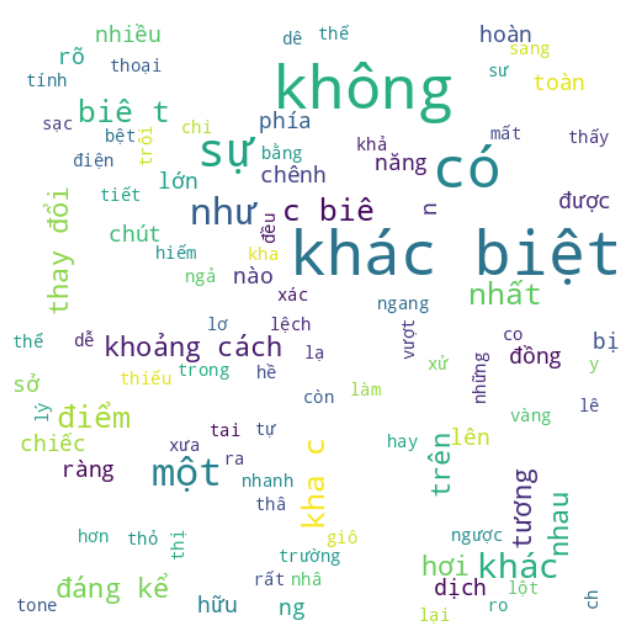




Label 'EQL' (287):
Some examples:
['không có nhiều thay đổi' 'khá giống nhau' 'đều sở hữu' 'trông giống như'
 'không có nhiều sự khác biệt'
 'đều mang đến những bức ảnh hấp dẫn người chụp'
 'không có quá nhiều chênh lệch' 'tương tự nhau'
 'Không có nhiều sự khác biệt' 'gần như ngang bằng nhau' 'đều có'
 'gần bằng nhau' 'cũng có' 'đều rất sắc nét' 'đều mang lại'
 'đều được hỗ trợ' 'đều'
 'được trang bị các loại chipset và hệ điều hành mới nhất hiện nay'
 'không có sự khác biệt lớn' 'Đều được sử dụng' 'tương tự' 'đều sử dụng'
 'giống như' 'sang trọng , tinh tế không khác gì' 'gần như không đáng kể'
 'gần như là giống nhau hoàn toàn' 'cũng khá giống' 'tương tự như'
 'đều khiến người dùng hài lòng' 'như' 'đều được hoàn thiện từ'
 'đều có thể' 'không hề kém cạnh' 'không có nhiều sự chênh lệch'
 'tương đương' 'đều có thể' 'khá giống' 'mức giá khá cao'
 'không lớn hơn nhiều' 'đều mang đến' 'ngang bằng' 'đều đã có'
 'gần tương đương' 'đều được trang bị' 'có' 

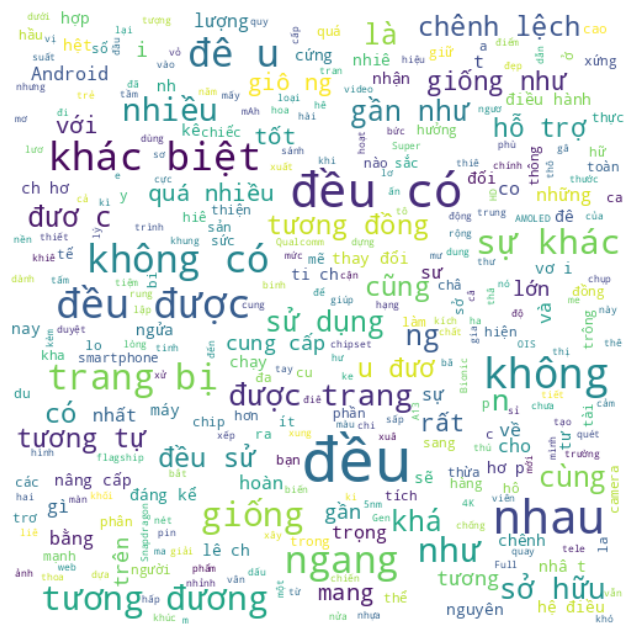

In [425]:
for label in ["DIF", "EQL"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  print(df_l.predicate.unique())
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Comparative group

- "COM+" predicates - 500q (*positive*):
  - Keywords: "hơn" - 415, tốt - 76, cao - 53, nhiều - 45

- "COM" predicates - 21q (*neutral*):
  - Keywords: "hơn" - 19.

- "COM-" predicates - 107q (*negative*):
  - Keywords: "hơn" - 64, thấp - 21, kém - 19, không - 18, thua - 8, yếu - 8


Label 'COM+' (500):
Some examples:
- khéo léo hơn
- nhanh hơn
- ít hơn
- cải thiện 70%
- nhanh gấp đôi
- tốt hơn
- lớn hơn
- nhỉnh hơn
- ấn tượng hơn
- hấp dẫn hơn

- Field 'subject':
  + Freq: 449
  + BoW:
    {'galaxy': 121, 'ultra': 84, 'samsung': 65, 'iphone': 53, 'pro': 50, 's23': 34, '11': 24, 'nó': 23, 'note': 23, '5g': 22, 's22': 21, 'điện': 21, 'thoại': 21, 'camera': 20, 'xiaomi': 20, '13': 20, 'của': 15, 'máy': 14, 's20': 14, 'max': 14, 'hình': 14, 'a51': 13, 'này': 12, 'z': 12, 's21': 12, 'redmi': 12, 'ảnh': 11, 'oppo': 11, 'find': 10, 'plus': 10, 'a32': 10, 'với': 9, 'n2': 9, 'flip': 9, '12': 9, 'mi': 9, 'chiếc': 9, 'trên': 8, '+': 8, 'mẫu': 8, 'a53': 8, 'màn': 8, '20': 8, 'a73': 7, 'snapdragon': 7, 'điện': 7, 'thoại': 7, 'apple': 7, 'fold2': 7, 'a13': 7, 'pixel': 7, '7': 7, 'p30': 7, 's-pen': 6, 'đi': 6, 'kèm': 6, 'mới': 6, 'smartphone': 6, '8': 6, '14': 6, 'realme': 6, 'x90': 6, 'flagship': 5, 'chip': 5, 'các': 5, 'di': 5, 'động': 5, 'chụp': 5, 'huawei': 5, '9': 4, 'a23

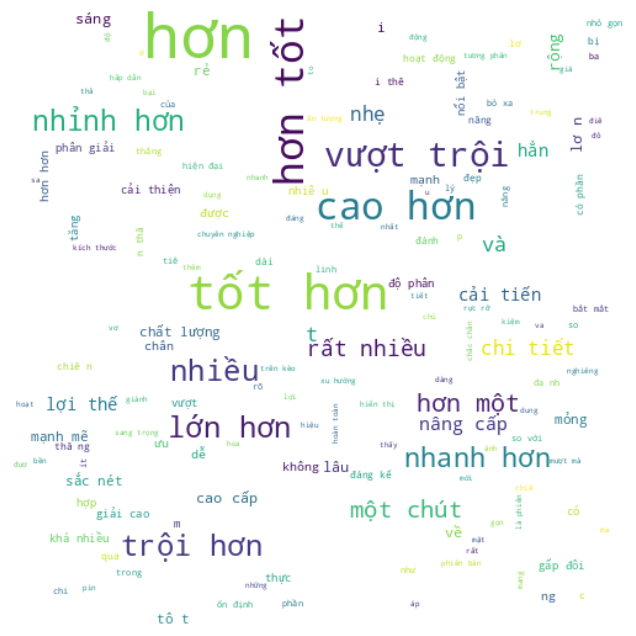




Label 'COM' (21):
Some examples:
- điều chỉnh hơn nữa
- nông hơn trong một số bức ảnh
- ít cong hơn
- vuông vắn hơn
- nhỏ gọn hơn
- lớn và nặng hơn
- rộng hơn
- tối hơn
- sáng hơn
- nhô lên hơi cao so với

- Field 'subject':
  + Freq: 19
  + BoW:
    {'galaxy': 6, 'ultra': 6, 'samsung': 3, 's22': 2, 'xiaomi': 2, 's23': 2, 'trên': 2, 'phiên': 2, 'bản': 2, 'này': 2, 'asus': 2, 'rog': 2, 'phone': 2, '2': 2, 'model': 1, 'đắt': 1, 'tiền': 1, 'hơn': 1, 's21': 1, '13': 1, 'pro': 1, 'cụm': 1, 'module': 1, 'hình': 1, 'chữ': 1, 'nhật': 1, 'chiếc': 1, 's-pen': 1, 'z': 1, 'fold3': 1, '5g': 1, 'dòng': 1, 'máy': 1, 'iphone': 1, '12': 1, 'mini': 1, 's20': 1, 'phần': 1, 'a23': 1}
- Field 'object':
  + Freq: 12
  + BoW:
    {'galaxy': 3, 'pro': 2, 'các': 2, 'iphone': 2, '/': 2, 's21': 1, 'ultra': 1, 'thế': 1, 'hệ': 1, 'tiền': 1, 'nhiệm': 1, 'đối': 1, 'thủ': 1, 'xiaomi': 1, '13': 1, 'mặt': 1, 'lưng': 1, 'hầu': 1, 'hết': 1, 'chiếc': 1, 'bút': 1, 'chúng': 1, 'ta': 1, 'từng': 1, 'thấy': 1, 'trê

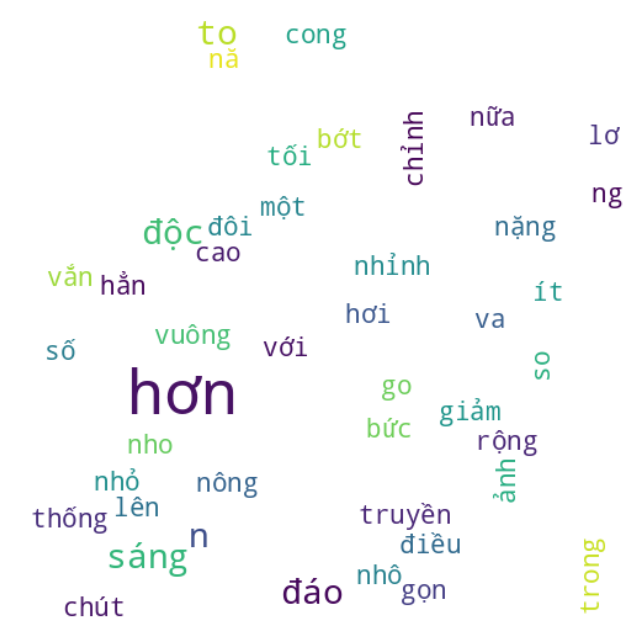




Label 'COM-' (107):
Some examples:
- nhỏ hơn một chút
- nhỏ hơn
- nhỏ hơn đôi chút
- không thể bằng được
- mắc hơn 1 chút
- kém hơn
- thấp hơn
- khó lòng sánh được
- không bằng
- có phần ngắn và hẹp hơn

- Field 'subject':
  + Freq: 88
  + BoW:
    {'galaxy': 23, 'nó': 15, 'samsung': 14, '+': 6, 'iphone': 5, 's23': 5, 'pro': 5, 'màn': 4, 'hình': 4, 'note': 4, 'máy': 4, 'ultra': 4, 'm51': 4, 'z': 3, 'flip': 3, 'của': 3, 'những': 3, 'này': 3, 'snapdragon': 3, 'oppo': 3, 'điện': 3, 'thoại': 3, '4': 2, '9': 2, 'a53': 2, 'chiếc': 2, 'trên': 2, 'thiết': 2, 'bị': 2, 'camera': 2, 'redmi': 2, '11': 2, '12': 2, 'google': 2, 'pixel': 2, '5': 2, '450': 2, 'sản': 2, 'phẩm': 2, 'cùng': 2, 'phân': 2, 'khúc': 2, 'giá': 2, 'smartphone': 2, 'di': 2, 'động': 2, 'm32': 2, '5g': 2, '2': 2, 'm31': 2, 'prime': 2, 'motorola': 2, 'one': 2, 'fusion': 2, 'phụ': 1, 's21': 1, 'fe': 1, 'android': 1, 'vi': 1, 'xử': 1, 'lý': 1, 'se': 1, '2022': 1, 'nó': 1, '50mp': 1, 'a51': 1, 'a31': 1, 'semới': 1, 'siêu'

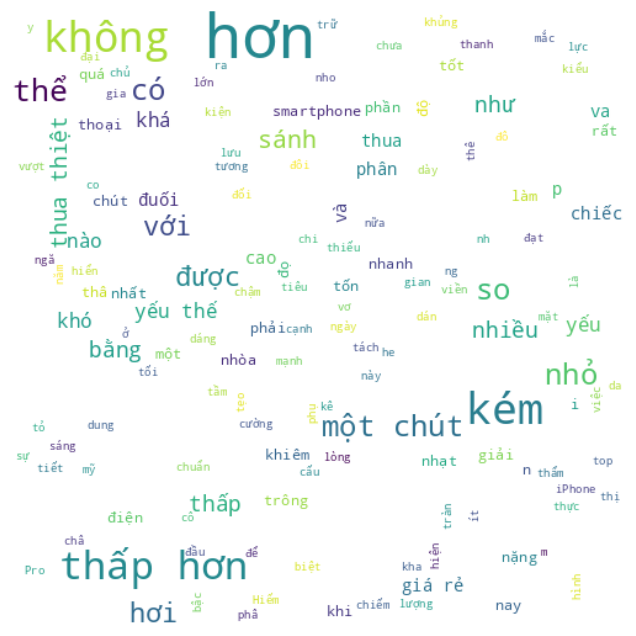

In [426]:
for label in ["COM+", "COM", "COM-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Superlative group

- "SUP+" predicates - 107 (*positive*):
  - Keywords: "nhất" - 85, tốt - 33, nay - 28, hiện - 25, cao - 15, mạnh - 14

- "SUP" predicates - 4 (*neutral*):
  - Keywords: "nhất" - 4, lớn - 2

- "SUP-" predicates - 5 (*negative*):
  - Keywords: "nhất" - 4, nhỏ - 2, đắt - 1



Label 'SUP+' (107):
Some examples:
- tốt nhất thế giới Android hiện nay
- sáng nhất trên bất kỳ điện thoại thông minh nào.Trong
- cao cấp nhất của thế giới Android hiện nay
- cao cấp nhất năm 2018
- tốt nhất cho đến nay
- tốt nhất trên thị trường
- nổi bật nhất trong dòng Galaxy A
- tốt nhất của hãng từ trước đến nay
- mạnh nhất hiện tại
- cao cấp nhất hiện nay

- Field 'subject':
  + Freq: 104
  + BoW:
    {'galaxy': 29, 'ultra': 18, 'iphone': 18, 'pro': 18, 'đây': 12, 'samsung': 10, 'max': 10, 's22': 7, '12': 7, 'note': 5, 'z': 5, 's21': 5, 'của': 4, 'hai': 4, '13': 4, 'pixel': 4, 'xiaomi': 3, 'apple': 3, 'điện': 3, 'thoại': 3, '5g': 3, 'cả': 3, 'se': 3, '2016': 3, '2': 3, '14': 3, 'plus': 3, 'chiếc': 3, '7': 3, 'a24': 3, '11': 3, 'm51': 3, 'dòng': 2, 'series': 2, 'sản': 2, 'phẩm': 2, 'smartphone': 2, 'fold': 2, '4': 2, 's23': 2, 'snapdragon': 2, 'máy': 2, 'oppo': 2, 'note20': 2, 'fold3': 2, 's10': 2, 'cấp': 2, 'redmi': 2, 'a15': 2, 'bionic': 2, 's20': 2, 'thiết': 2, 'bị': 2, 

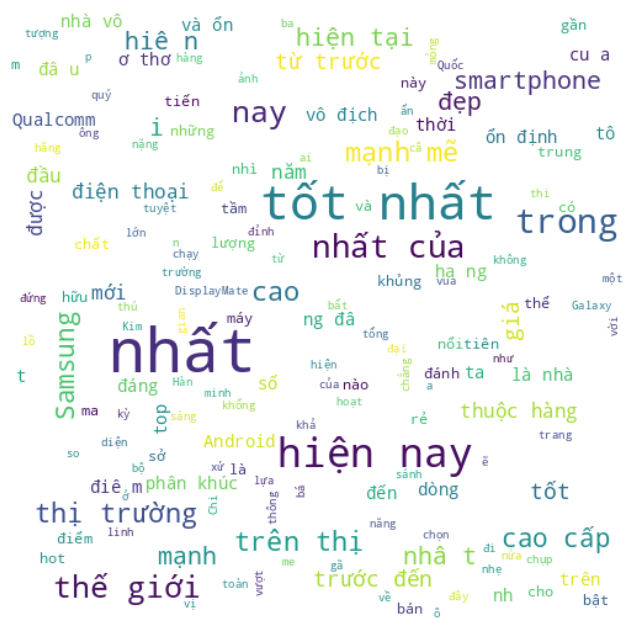




Label 'SUP' (4):
Some examples:
- lớn nhất từ trước đến nay
- không còn là cấu hình mạnh mẽ nhất trong thế giới smartphone nữa
- nhỏ nhất
- lớn nhất trong Galaxy S20 Series vừa ra mắt

- Field 'subject':
  + Freq: 4
  + BoW:
    {'galaxy': 2, 'iphone12': 1, 'pro': 1, 'max': 1, 'đây': 1, 's23': 1, 'hộp': 1, 'đựng': 1, 's20': 1, 'ultra': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 4
  + BoW:
    {'hình': 2, 'màn': 1, 'cấu': 1, 'phiên': 1, 'bản': 1, 'kích': 1, 'thước': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'lớn': 2, 'trong': 2, 'từ': 1, 'trước': 1, 'đến': 1, 'nay': 1, 'không': 1, 'còn': 1, 'là': 1, 'cấu': 1, 'hình': 1, 'mạnh': 1, 'mẽ': 1, 'thế': 1, 'giới': 1, 'smartphone': 1, 'nữa': 1, 'nhỏ': 1, 'galaxy': 1, 's20': 1, 'series': 1, 'vừa': 1, 'ra': 1, 'mắt': 1}



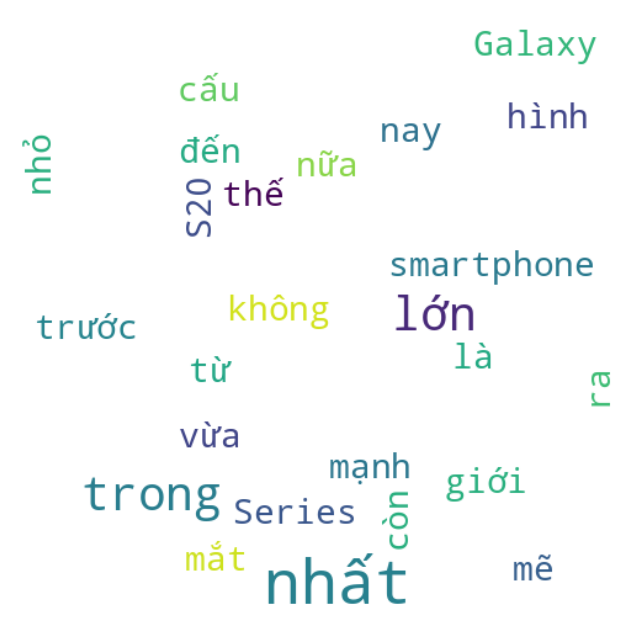




Label 'SUP-' (5):
Some examples:
- nhỏ nhất
- đứng vị trí cuối cùng
- ngắn nhất
- đắt nhất của Samsung

- Field 'subject':
  + Freq: 5
  + BoW:
    {'realme': 2, '6': 2, 'pro': 2, 'camera': 1, 'tele': 1, 'pixel': 1, '5': 1, 'galaxy': 1, 'z': 1, 'flip': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 4
  + BoW:
    {'pin': 2, 'kích': 1, 'thước': 1, 'cảm': 1, 'biến': 1, 'chụp': 1, 'ảnh': 1, 'thời': 1, 'lượng': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'nhỏ': 2, 'đứng': 1, 'vị': 1, 'trí': 1, 'cuối': 1, 'cùng': 1, 'ngắn': 1, 'đắt': 1, 'của': 1, 'samsung': 1}



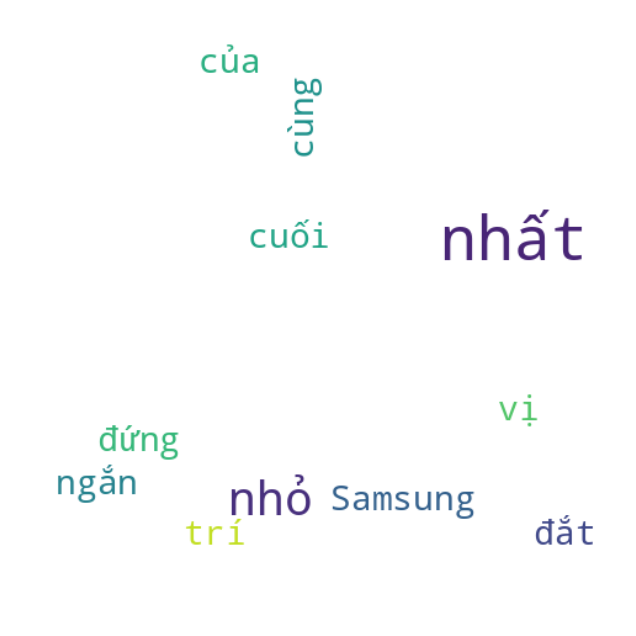

In [427]:
for label in ["SUP+", "SUP", "SUP-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

#### Relate the fields to each others



- Incorrect object?

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|831|Về chất lượng hiển thị , so sánh iPhone XS và iPhone 11 thì iPhone XS có phần trội hơn \.|iPhone XS|iPhone XS|chất lượng hiển thị|có phần trội hơn|COM+|
|1476|Với điện thoại màn hình gập Galaxy Z Fold 4 sẽ mang đến không gian hiển thị linh hoạt hơn với 2 màn hình \.|điện thoại màn hình gập Galaxy Z Fold 4|điện thoại màn hình gập Galaxy Z Fold 4|không gian hiển thị|linh hoạt hơn|COM+|

In [428]:
# subject == object: 130
# 128 are either DIF or EQL; 2 is COM+
# flattened_train_df[flattened_train_df.predicate.notna()].query("subject == object & subject.str.contains('.{1,}', na=False)")



### 4. Exporting dataset

In [429]:
# This output dataset should be result of the "shallow" cleaning process
# performed in the section "I.2. Analyzing sentences" .
train_df.to_csv("post_analysis_training_dataset.csv", index=False)

## II. Analysis on development dataset

In [431]:
# Original set (before modified)
train_df = DEV_DF.copy()
len(train_df)

1732

### 1. Counting sentences on number of quintuples

breaked
    + 1 quintuple: 248
    + 2 quintuples: 82
    + 3 quintuples: 17
    + 4 quintuples: 2
    + >= 5 quintuples: 0

=> Imbalance between number of datapoints with no quintuple and others
  
after: ['1 quintuple', '2 quintuples', '3 quintuples', '4 quintuples']
[0.05, 0.04, 0.05, 0.06]
[248, 82, 17, 2]


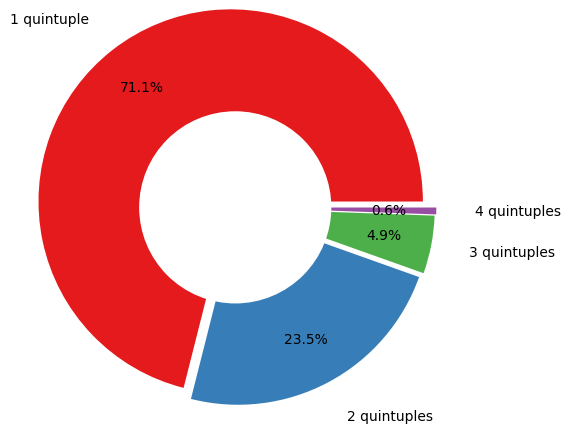

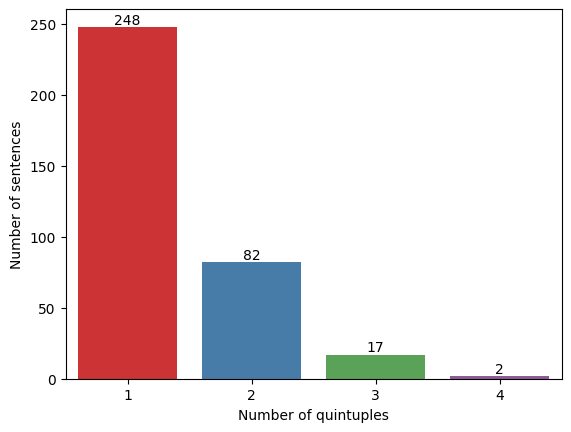

In [432]:
relate_sentences_to_quintuple_counter(DEV_DF, from_quins=1)

### 2. Analyzing sentences

Conclusions: (not modified yet)
- Most of the sentences start with a capitalized word and end with a '.' (>2600).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences is about *4 times* larger than number of sentences with quin (**1383**/**349**).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

⇒ Result: **816**/**349** (non-quin/quin-owner) left (ratio 2.5:1).

#### General stats (before modifying DF)

In [433]:
print(f"Num of zero-quin sentences: {len(train_df[train_df.quintuples.isna()])}")
print(f"Num of quin-owner sentences: {len(train_df[train_df.quintuples.notna()])}")

Num of zero-quin sentences: 1383
Num of quin-owner sentences: 349


##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- Critically imbalance between quin-owning and non-quin, especially in the range of 1-9 tokens.
- An abnormally large number of sentences have 1-8 tokens.

⇒ The need for identifying reasons & solutions, which aims to <u>make the uneven data more balance</u>.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query) 129
       num_of_tokens
count    1732.000000
mean       19.116051
std        12.925724
min         1.000000
25%         9.000000
50%        18.000000
75%        26.000000
max        72.000000


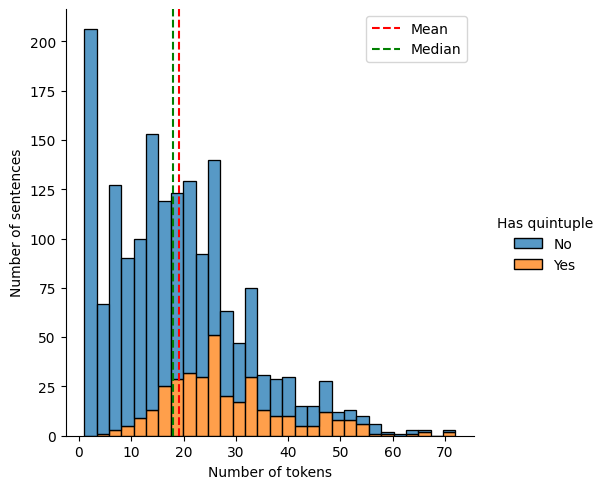

In [434]:
# @title
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {len(df.query('num_of_tokens >= 8 & num_of_tokens <= 10'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### a. "Sentences" start with numbers
Conclusion: Most of the "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [435]:
print(f"Original size of training set: {len(train_df)}")

# Remove "sentences" start with numbers
train_df.drop(train_df[train_df.sentence.str.match("^\d{1,}(\W\d{1,}){0,} {1,}\W{1,}")].index.tolist(), inplace=True) # 58
train_df.drop(train_df[train_df.sentence.str.match("^\d{1,}\w{1,}")].index.tolist(), inplace=True) # exception; e.g. 1Thiet ke

print(f"Size of training set after modified: {len(train_df)}")

Original size of training set: 1732
Size of training set after modified: 1667


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command:

(should do this after all other steps)

In [436]:
# @title
""" Check if any sentence is duplicated """

# train_df = DEV_DF.copy()
print(f"Size of the training set before modified: {len(train_df)}")

dups = train_df[train_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Quin-owner: {len(dups_with_quin)}")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(train_df[train_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

# remove duplicates
remove_duplicates(train_df, mode="first-except-quin-owner", inplace=True)

print(f"Size of the training set after modified: {len(train_df)}")

Size of the training set before modified: 1667
Number of duplicates: 163
Quin-owner: 0
163 will be deleted
Size of the training set after modified: 1504


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/0
  - des: 499/216/24(23 unique)
  - alt: 500/332/1

  (always at the first position of the sentences)

  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt ?: )|(des ?: )|(title ?: )|(src ?: )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions and titles, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).
  - Sentences ending with '!' mostly don't have quin (except 1).

  => Propose deleting:
    - All '?' & 'title' sentences: 170
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset.
=> Continue removing duplicates by the recommended command above.

In [437]:
# @title
"""
In this section (and maybe others), I define a "special sentence"
is a sentence containing "alt", "des", "title" or "?", "src" (from test set).
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may have been filtered out (or not) before examining.
"""

# train_df = DEV_DF.copy()

questions_and_titles = train_df[train_df.sentence.str.match("(\?)|([Tt][Ii][Tt][Ll][Ee])|([Ss][Rr][Cc])")]
special_sentences = train_df[train_df.sentence.str.match("([Aa][Ll][Tt])|([Dd][Ee][Ss])")]
print()

## Questions & titles
# print(len(train_df[train_df.sentence.str.contains("title")]))
# print(len(train_df[train_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: Most of the sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove "Title :" in quin-owners & remove remaining questions and titles
titles = train_df[train_df.sentence.str.contains("^[Tt][Ii][Tt][Ll][Ee]")]
questions = questions_and_titles.drop(titles.index.tolist())

for i, s in titles.sentence.items():
  new_sent = regex.sub("(Title ?: ?)|(title ?:? ?)", "", s)
  train_df.sentence.replace(s, new_sent, inplace=True)

train_df.drop(titles[titles.quintuples.isna()].index.tolist(), inplace=True)
train_df.drop(questions.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")

tmp = len(train_df[train_df.sentence.duplicated()])

print(f"Dups before removing 'des : ' & 'alt : ': {tmp}")

# Substitute "(des : ?)|(alt : ?)" with "" and replace old strings with those in train_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des ?:? ?)|(alt ?:? ?)", "", special_sentences.iloc[i].sentence)
  train_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(train_df[train_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{train_df[train_df.sentence == new_sent]}\n")


print(f"Dups after removing 'des : ' & 'alt : ': {len(train_df[train_df.sentence.duplicated()])}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset ({len(train_df[train_df.sentence.duplicated()]) - tmp} increased)"""
)

# new_dups = train_df[train_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"Tuple {i}:")
#   print(train_df[train_df.sentence == new_dups.iloc[i].sentence], end="\n")

# uncomment the code above to print all tuples
print("""
After observing all the duplicates (determined by the sentence column),
we can conclude that in each duplicate tuple, not all members are the same.
(Note that tuples of 'similar' members may be not included yet. For example:
"Điện thoại" vs "Điện thoại .")
"""
)


Sentences containing '?' and/or 'title : ' (25) and having quintuple: 0
=> Conclusion 3: Most of the sentences containing '?' and/or 'title : ' should be removed.

Number of special sentences starting with 'des : ', 'alt : ': 253
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 7
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ': 0
Dups after removing 'des : ' & 'alt : ': 96

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (96 increased)

After observing all the duplicates (determined by the sentence column),
we can conclude that in each duplicate tuple, not all members are the same.
(Note that tuples of 'similar' members may be not included yet. For example:
"Điện thoại" vs "Điện thoại .")



In [438]:
# Remove duplicates
print(f"Size of the training set before modified: {len(train_df)}")
remove_duplicates(train_df, mode="all-non-quin", inplace=True)
print(f"Size of training set after modified: {len(train_df)}")

Size of the training set before modified: 1479
182 will be deleted
Size of training set after modified: 1297


#### d. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.

**Conclusion 6**: Most of "short" sentences does not contain quintuple. Specifically, we can remove all sentences with 0-3 tokens and consider to remove sentences with 4-7 tokens (but the sentences with quintuple should be kept).


- Sentences with ...
(Pattern: `<total of sentences> - <sentences contain quintuple>`)
  - 0-3 tokens: 163 - 0
  - 4 tokens: 54 - 1
  - 5 tokens: 51 - 2
  - 6 tokens: 55 - 3
  - 7 tokens: 78 - 3
  - 8 tokens: 74 - 7

    ...

In [439]:
# @title
""" Examine sizes of the training sentences """
MINIMUM_NUM_OF_TOKENS = 7
# train_df = DEV_DF.copy()
print(f"Size of training set before modified: {len(train_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = train_df.loc[[item[0] for item in train_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")
  print(f"=> Delete: {len(short_sentences) - len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  train_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"training size: {len(train_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of training set after modified: {len(train_df)}\n")

Size of training set before modified: 1297

Given minimum number of tokens is 0.
Number of short sentences: 0
Number of short sentences with quin: 0
=> Delete: 0

Given minimum number of tokens is 1.
Number of short sentences: 4
Number of short sentences with quin: 0
=> Delete: 4

Given minimum number of tokens is 2.
Number of short sentences: 16
Number of short sentences with quin: 0
=> Delete: 16

Given minimum number of tokens is 3.
Number of short sentences: 18
Number of short sentences with quin: 0
=> Delete: 18

Given minimum number of tokens is 4.
Number of short sentences: 23
Number of short sentences with quin: 1
=> Delete: 22

Given minimum number of tokens is 5.
Number of short sentences: 22
Number of short sentences with quin: 1
=> Delete: 21

Given minimum number of tokens is 6.
Number of short sentences: 32
Number of short sentences with quin: 2
=> Delete: 30

Given minimum number of tokens is 7.
Number of short sentences: 23
Number of short sentences with quin: 2
=> Dele

#### e. Others


In [440]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = flattened_train_df.drop(flattened_train_df[flattened_train_df.sentence.str.contains("^\d*[(\\.\d*)]+\W{1,}")].index.tolist())
# df = flattened_train_df

# print(len(flattened_train_df.sentence.unique()))
query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
# ending_dots = df[df.sentence.str.contains(r"")]#.query("label.isna()")
# ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())

<ipython-input-440-a359702e2685>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")


sentence  \
314   Xiaomi Mi 11 sở hữu màn hình nền AMOLED có thể...   
401   Một số tính năng đặc biệt cũng có ở Galaxy A73...   
483       Title : Đánh giá iPhone SE 2022 : Khoan . . .   
620   Tỷ lệ màn hình chính của Samsung Galaxy ...   
663   Trong khi Samsung Z Fold 4 được cung cấp viê...   
687   Khi đánh giá Samsung Galaxy S22 Ultra 5G và Ga...   
799   Bộ 4 camera với nhiều tính năng hiện đại...   
889   Giúp người dùng thoải mái lướt web , chơ...   
966   Nếu bạn thích trải nghiệm một chiếc điê...   
1045  Điểm đáng cân nhắc nhất khi lựa chọn Galaxy A5...   
1373  Các điện thoại giá rẻ như Google Pixel 5A...   
1530  Trong khi iPhone 12 Pro Max bắt đầu từ mức giá...   
1565  Google Pixel 6 Pro sở hữu 3 camera sau với ống...   
1566  Như đã nói , iPhone 13 Pro được trang bị cụm c...   
1607  Không những vậy , điện thoại cũng được tr...   
1733  Mặt khác , bạn có thể nhận được dung lượng lưu...   
1734  Mặt khác , bạn có thể nhận được dung lượng lưu...   
1746  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
1747  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
1748  Samsung Galaxy M52 5G thực sự có thời lượng pi...   
1890  Galaxy A11 chạy hệ điều hành Android 10 với tù...   
1982  Galaxy A11 trang bị viên pin Li-Po 4.000 mAh ....   
2190  Không chỉ có camera xịn xò , vô số các t...   
2221  Nếu bạn là học sinh - sinh viên hay những...   
2597  Phải nói năm nay Samsung chơi lớn trên những c...   
2766  Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
2767  Redmi Note 11 có bộ phận phần cứng tiên tiến n...   
2784  Cả ba smartphone này đều sở hữu viên pin có du...   
2785  Cả ba smartphone này đều sở hữu viên pin có du...   
2786  Cả ba smartphone này đều sở hữu viên pin có du...   
2802  Máy có thiết kế nguyên khối trẻ trung , đi kèm...   
2810  Thiết bị sở hữu màn hình Super AMOLED kích thư...   
2829  Ngoài ra , tần số quét của hai màn hình là 120...   
2837  Hai bộ camera này chính là chân ái của người d...   
2919  Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
2920  Samsung Galaxy A03s nổi bật với hệ thống 3 cam...   
2924  Trên Vivo Y21 có camera kép bao gồm camera chí...   
2929  Samsung Galaxy A03s và Vivo Y21 đều mang trên ...   
2933  Ưu điểm thường thấy trên smartphone giá rẻ là ...   
2941  Riêng cá nhân mình , thì mình sẽ nghiêng về Ga...   
3016  So sánh một chút với chiếc Realme 6 hoặc Realm...   
3052  Trước khi nói về khả năng chơi game , mình thấ...   
3152  Nó đi kèm sạc nhanh 25W , vẫn là nhanh nhưng đ...   
3226  Galaxy S20 Ultra đã chính thức được Samsung gi...   
3439  Camera hỗ trợ những tính năng nổi bật như chụp...   
3478  Dòng điện thoại này được hỗ trợ thêm những tín...   
3507  Thông qua những so sánh ở trên đã chỉ ra 2 chi...   
3938  Realme 6 Pro có màn hình IPS , nhưng nó có tốc...   
4068  iPhone 14 được nhà sản xuất sử dụng chipset A1...   
4307  Xét về pin giữa A23 và A32 về dung lượng pin t...   
4308  Xét về pin giữa A23 và A32 về dung lượng pin t...   

                     subject  \
314        smartphone Xiaomi   
401                      NaN   
483                      NaN   
620                      NaN   
663                      NaN   
687                      NaN   
799                      NaN   
889    kích thước 7,6 inch   
966                      NaN   
1045                     NaN   
1373                     NaN   
1530                     NaN   
1565                     NaN   
1566           iPhone 13 Pro   
1607            điện thoại   
1733     Redmi Note 11 Pro +   
1734      hai smartphone này   
1746   Samsung Galaxy M52 5G   
1747                      nó   
1748     Redmi Note 11 Pro +   
1890            hệ điều hành   
1982              Galaxy A11   
2190                     NaN   
2221                     NaN   
2597                     NaN   
2766           Redmi Note 11   
2767                      nó   
2784   Samsung Galaxy M32 5G   
2785                      nó   
2786              

In [441]:
train_df[train_df.sentence.str.match("^\W")]

sentence  \
122   - Hư gì đổi nấy 12 tháng tại 3135 siêu thị toà...   
123   - Bảo hành chính hãng điện thoại 1 năm tại các...   
238              - Bảo hành có cam kết trong 12 tháng .   
239   - Bảo hành chính hãng 1 năm tại các trung tâm ...   
357                          - Hư gì đổi nấy 12 tháng .   
801   - Hư gì đổi nấy 12 tháng tại các siêu thị toàn...   
802            - Bảo hành chính hãng điện thoại 1 năm .   
803   - Luôn nhận được sự chăm sóc khách tận tình từ...   
926   ( Bạn có thể tham khảo thông tin sản phẩm tại ...   
1261  - Giá của Samsung Galaxy A03s và Vivo Y21 là b...   
1263         + Samsung Galaxy A03s có giá : 3.490.000 ₫   
1264                    + Vivo Y21 có giá : 4.290.000 ₫   
1265  - Nên sở hữu Samsung Galaxy A03s hay Vivo Y21 ?   
1603  “ Sức khoẻ ” vượt trội hơn sẽ giúp chiếc máy n...   

                                             quintuples  
122                                                None  
123                                                None  
238                                                None  
239                                                None  
357                                                None  
801                                                None  
802                                                None  
803                                                None  
926                                                None  
1261                                               None  
1263                                               None  
1264                                               None  
1265                                               None  
1603  [{'subject': 'chiếc máy này', 'object': '', 'a...

#### General stats (after modifying DF)

In [442]:
print(f"Num of zero-quin sentences: {len(train_df[train_df.quintuples.isna()])}")
print(f"Num of quin-owner sentences: {len(train_df[train_df.quintuples.notna()])}")

Num of zero-quin sentences: 816
Num of quin-owner sentences: 349


##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'Viên pin nhỏ hơn', 'num_of_tokens': 4}

(Test query) 4

       num_of_tokens
count    1165.000000
mean       24.902146
std        11.432787
min         4.000000
25%        17.000000
50%        23.000000
75%        31.000000
max        72.000000


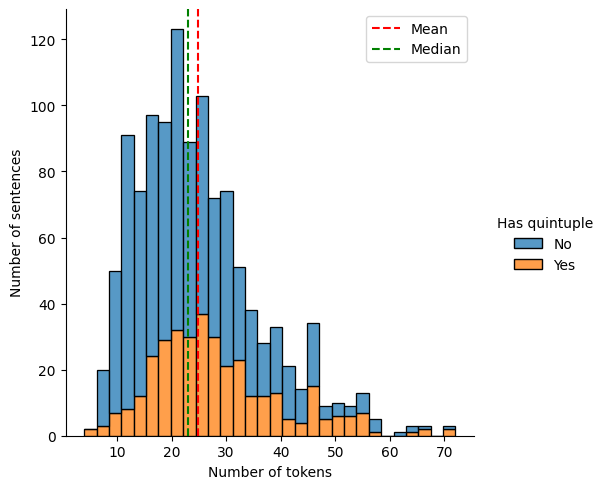

In [443]:
# @title
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in train_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = train_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]
df["Has quintuple"] = ["Yes" if q is not None else "No" for q in df.quintuples]

print(f"(Test query) {len(df.query('num_of_tokens >= 50 & num_of_tokens <= 50 & quintuples.notna()'))}\n")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist", hue="Has quintuple", multiple="stack")
# plt.legend(title="Have at least 1 quintuple", labels=["True", "False"])
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

### 3. Analyzing quintuple fields

Note: may need to validate word's indexes in quintuples

#### a. subject

###### General reviews

- A subject can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro"...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới"...
  - a phrase showing (owning) relationship between 2 nouns: "điện thoại đắt tiền hơn của Apple", "Các bức ảnh chụp với S20", "Màn hình của Redmi Note 11 Pro +", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 3 chiếc máy", ...
  - more complicated form: "các cổng kết nối cùng nút bấm", "Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa", "Chip A15 Bionic cung cấp hiệu năng khủng cho iPhone 13", ...
- There're some presences of miss spelling ("ấn tượn" -> "ấn tượng"), lack of spaces ("SEmới) ... This typing errors are trivial & quite rare.

  ⇒ should be corrected.

- Length: 1-16,
  - The distribution is mainly in range 1-6.
  - Subjects with length 9-16 rarely exist.
- Presences of non-word characters ('+', '-', ',', '.', '/', etc):

  ...

- Total of blank subjects / All quintuples: 53/471
- Total of non-blank unique subjects / Non-blank subjects: 178/418

Longest:
  {'subject': 'Cả hai chiếc flagship thế hệ mới nhất từ Xiaomi và Apple', 'tokens': ['Cả', 'hai', 'chiếc', 'flagship', 'thế', 'hệ', 'mới', 'nhất', 'từ', 'Xiaomi', 'và', 'Apple'], 'length': 12}
Shortest:
  {'subject': 'nó', 'tokens': ['nó'], 'length': 1}


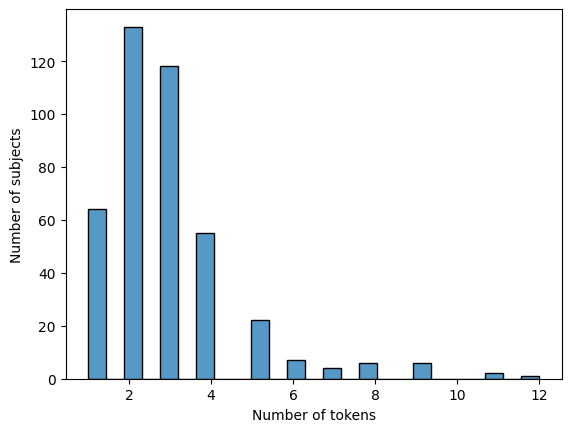

In [444]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.subject.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank subjects / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

df = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)]

subjects = df.subject
unique_subjects = df.subject.unique().tolist()

print(f"- Total of non-blank unique subjects / Non-blank subjects: {len(unique_subjects)}/{len(subjects)}")
print()

tokenized_subjects = []

for s in subjects:
  tokens = nltk.word_tokenize(s)
  tokenized_subjects.append({
      "subject": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_subject = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_subjects)
shortest_subject = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_subjects)

print(f"Longest:\n  {longest_subject}")
print(f"Shortest:\n  {shortest_subject}")

subjects_lengths: list[int] = [s.get("length") for s in tokenized_subjects]

sbn.histplot(pd.Series(subjects_lengths), bins=25)
plt.xlabel("Number of tokens")
plt.ylabel("Number of subjects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in subjects. => most of datasets come from 'electronic device reviews', especially in topics about 'cellphone', 'camera'.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" always goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "chiếc" - 29,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [445]:
nonblank_values = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)].subject

In [446]:
""" Bag-of-Words """
subject_bow: dict[str, int] = make_BoW(nonblank_values)
print(subject_bow)
print(f"Size of BoW: {len(subject_bow)}")

{'galaxy': 107, 'hai': 59, 'iphone': 56, 'samsung': 44, 'cả': 42, 'điện': 38, 'thoại': 38, 'chiếc': 32, 's22': 26, 'này': 25, '13': 25, '2': 21, 'của': 20, 'xiaomi': 19, 'nó': 18, 'máy': 16, '5g': 16, 'z': 16, '11': 16, '12': 16, 'oppo': 14, 'google': 14, 'hình': 13, 's10': 12, 'f9': 12, 'màn': 11, 'a03s': 11, 'flagship': 11, 'pixel': 11, 'a31': 10, 'sản': 10, 'phẩm': 10, 'vivo': 9, 's23': 9, 'pro': 8, 'ultra': 8, 'oneplus': 8, 'mi': 8, 'dòng': 8, 'fold': 8, 'camera': 7, 'các': 7, 'flip': 7, 's21': 6, '+': 6, 'max': 6, 'smartphone': 5, 'từ': 5, 'phiên': 5, 'cả': 5, 'mới': 5, 'apple': 5, 'mẫu': 5, 'a73': 5, 'thiết': 5, 'bị': 5, 'nhà': 5, '7a': 5, 'plus': 5, 'xs': 5, 'a12': 4, 'chất': 4, 'a13': 4, '4gb': 4, 'đến': 4, 'm31s': 4, 'bản': 4, 'hệ': 4, 'điện': 4, 'thoại': 4, '10': 4, 'mới': 4, 't1': 4, '6': 4, 'a32': 3, 'sau': 3, 'ảnh': 3, 'snapdragon': 3, 'android': 3, 'và': 3, 'trên': 3, 'táo': 3, 'khuyết': 3, 'đây': 3, 'chipset': 3, 'y21': 3, 'những': 3, 'di': 3, 'động': 3, 'a33': 2, 'l

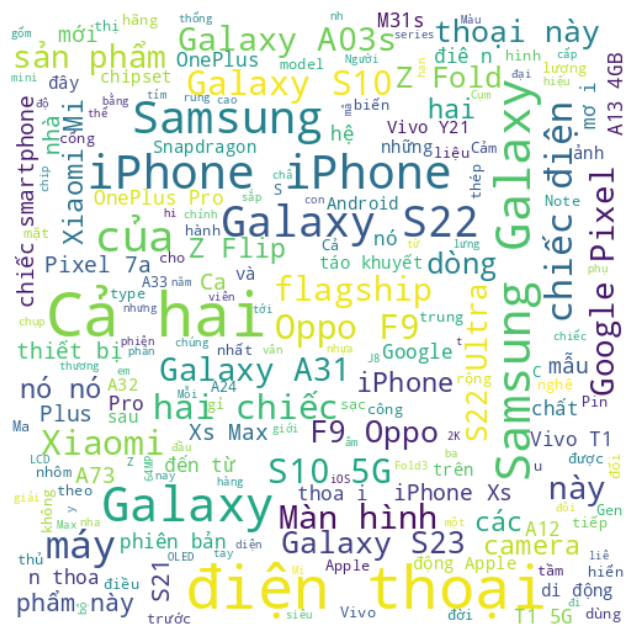

In [447]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [448]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ -
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
filt = [s for s in nonblank_values if re.match(".{0,}chiếc.{0,}", s.lower())]
len(filt)

32

#### b. object

###### General reviews

- An object can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An object may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank objects / All quintuples: 154/471
- Total non-blank unique object / Non-blank objects: 151/317
Longest:
  {'object': 'màn hình dạng giọt nước đã " quá cổ " của chiếc T1 5G', 'tokens': ['màn', 'hình', 'dạng', 'giọt', 'nước', 'đã', '``', 'quá', 'cổ', '``', 'của', 'chiếc', 'T1', '5G'], 'length': 14}
Shortest:
  {'object': 'A12', 'tokens': ['A12'], 'length': 1}



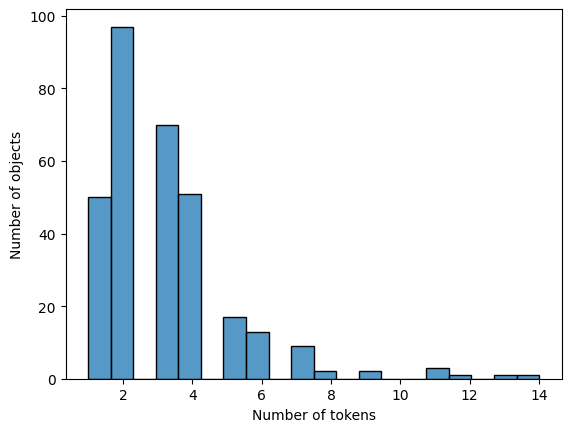

In [449]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.object.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank objects / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)]

objects = df.object
unique_objects = objects.unique().tolist()

print(f"- Total non-blank unique object / Non-blank objects: {len(unique_objects)}/{len(objects)}")

tokenized_objects = []

for s in objects:
  tokens = nltk.word_tokenize(s)
  tokenized_objects.append({
      "object": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_object = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_objects)
shortest_object = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_objects)

print(f"Longest:\n  {longest_object}")
print(f"Shortest:\n  {shortest_object}\n")

objects_lengths: list[int] = [s.get("length") for s in tokenized_objects]

sbn.histplot(pd.Series(objects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of objects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại", "cả" ... are some of the most popular words in objects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "thế hệ", "tiền nhiệm" ... All of these are Vietnamese compound words; member words always stand together.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [450]:
# Execute this first
nonblank_values = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)].object

In [451]:
""" Bag-of-Words """
object_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in object_bow.items() if i[1] < 3])
print(f"Size of BoW: {len(object_bow)}")

[('ở', 2), ('a32', 2), ('hiện', 2), ('20', 2), ('a31', 2), ('ra', 2), ('trong', 2), ('định', 2), ('lựa', 2), ('chọn', 2), ('kính', 2), ('anh', 2), ('điện', 2), ('thoại', 2), ('các', 2), ('khác', 2), ('dòng', 2), ('mới', 2), ('tiền', 2), ('nhiệm', 2), ('chúng', 2), ('10', 2), ('model', 2), ('nó', 2), ('5g', 2), ('``', 2), ('được', 2), ('dùng', 2), ('cho', 2), ('14', 2), ('phần', 2), ('còn', 2), ('lại', 2), ('giới', 2), ('184g', 1), ('a33', 1), ('đa', 1), ('số', 1), ('cao', 1), ('cấp', 1), ('s20', 1), ('huawei', 1), ('mate', 1), ('rẻ', 1), ('a13', 1), ('cạnh', 1), ('tranh', 1), ('thương', 1), ('hiệu', 1), ('trung', 1), ('2020', 1), ('m51', 1), ('gần', 1), ('đây', 1), ('2019', 1), ('phân', 1), ('khúc', 1), ('mặc', 1), ('ổn', 1), ('quang', 1), ('học', 1), ('amoled', 1), ('giống', 1), ('như', 1), ('người', 1), ('em', 1), ('mình', 1), ('mỗi', 1), ('màn', 1), ('hình', 1), ('mẫu', 1), ('nhất', 1), ('oppo', 1), ('f9', 1), ('dạng', 1), ('giọt', 1), ('nước', 1), ('đã', 1), ('quá', 1

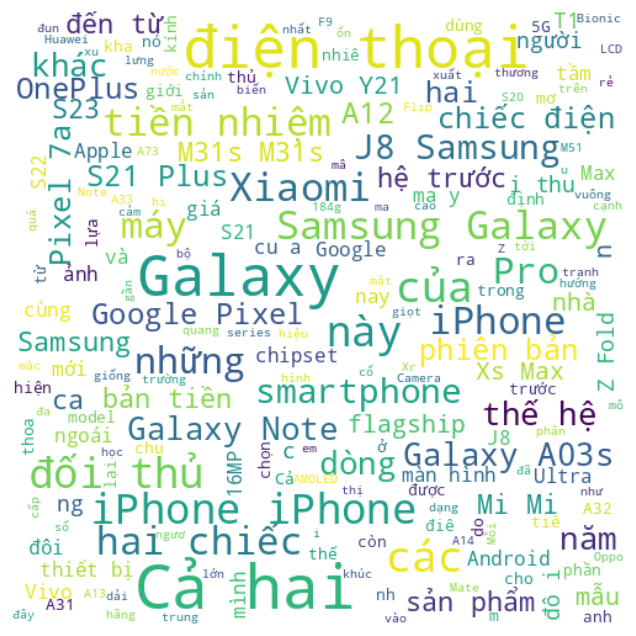

In [452]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [453]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}thoại.{0,}", s.lower())]
# filt

#### c. aspect

###### General reviews *(not modified yet)*

- An aspect can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An aspect may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank aspects / All quintuples: 68/471
- Total non-blank unique aspect / Non-blank aspects: 278/403
Longest:
  {'aspect': 'những nét nổi bật trong thiết kế , tính năng cũng như chất lượng sản phẩm', 'tokens': ['những', 'nét', 'nổi', 'bật', 'trong', 'thiết', 'kế', ',', 'tính', 'năng', 'cũng', 'như', 'chất', 'lượng', 'sản', 'phẩm'], 'length': 16}
Shortest:
  {'aspect': 'Camera', 'tokens': ['Camera'], 'length': 1}



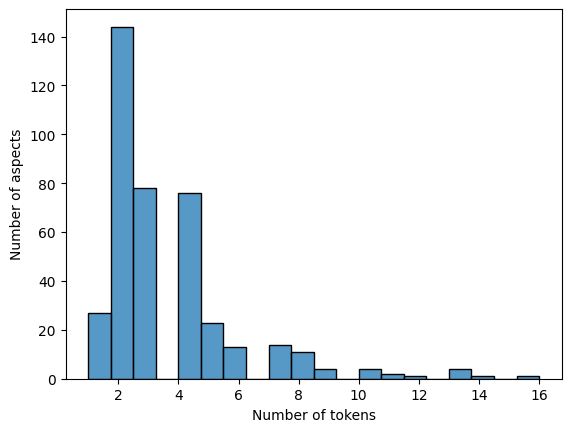

In [454]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.aspect.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank aspects / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)]

aspects = df.aspect
unique_aspects = aspects.unique().tolist()

print(f"- Total non-blank unique aspect / Non-blank aspects: {len(unique_aspects)}/{len(df)}")

tokenized_aspects = []

for s in aspects:
  tokens = nltk.word_tokenize(s)
  tokenized_aspects.append({
      "aspect": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_aspect = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_aspects)
shortest_aspect = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_aspects)

print(f"Longest:\n  {longest_aspect}")
print(f"Shortest:\n  {shortest_aspect}\n")

aspects_lengths: list[int] = [s.get("length") for s in tokenized_aspects]

sbn.histplot(pd.Series(aspects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of aspects")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in aspects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "tiền nhiệm", "thế hệ", "thị trường" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [455]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

nonblank_values = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)].aspect

In [456]:
""" Bag-of-Words """
aspect_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in aspect_bow.items() if i[1] > 6])
print(f"Size of BoW: {len(aspect_bow)}")

[('hình', 48), ('camera', 36), ('màn', 33), ('lượng', 31), ('pin', 28), ('năng', 26), ('ảnh', 25), ('độ', 25), ('thiết', 24), ('kế', 23), ('sạc', 20), ('hiệu', 16), ('thời', 14), ('phần', 12), ('dụng', 11), ('mặt', 11), ('tốc', 11), ('chất', 11), ('sử', 10), ('tính', 10), ('suất', 10), ('thước', 10), ('chụp', 10), ('số', 9), ('máy', 9), ('gian', 9), ('và', 9), ('lưng', 9), ('những', 9), ('dung', 9), ('công', 9), ('viên', 9), ('xử', 9), ('lý', 9), ('kích', 9), ('hệ', 9), ('giá', 8), ('bộ', 8), ('cảm', 8), ('khung', 7), ('kính', 7), ('phân', 7), ('giải', 7), ('trải', 7), ('nghiệm', 7), ('cụm', 7), ('khả', 7), ('màu', 7), ('viền', 7)]
Size of BoW: 456


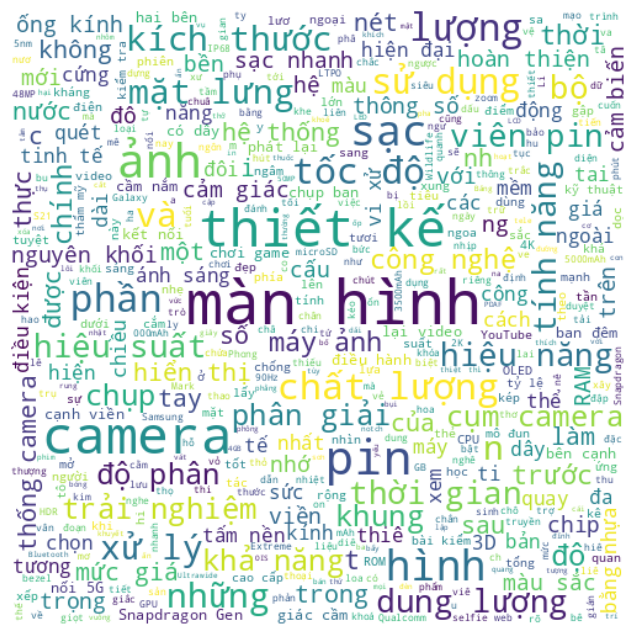

In [457]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=450, background_color="white")

In [458]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}hệ.{0,}", s.lower())]
filt

['công nghệ tấm nền OLED mới nhất của Samsung',
 'những công nghệ hiện đại',
 'hệ điều hành',
 'Công nghệ sạc nhanh',
 'công nghệ kết nối 5G tương lai thời thượng',
 'công nghệ LTPO',
 'những vi xử lý thế hệ mới nhất hiện nay',
 'hệ thống camera',
 'hệ điều hành',
 'công nghệ',
 'Hệ thống camera',
 'hệ thống camera',
 'hệ điều hành',
 'hệ thống camera',
 'hệ thống camera kép']

#### d. predicate

###### General reviews *(not modified yet)*

- A predicate can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- A predicate may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank predicates / All quintuples: 0/471
- Total non-blank unique predicate / Non-blank predicates: 332/471
Longest: 18 (1 results). Example:
  {'predicate': 'đều đáp ứng tốt nhu cầu của người dùng ở mức cơ bản chỉ với một lần sạc', 'length': 18, 'sentence': 'Trải nghiệm thực tế cho thấy cả hai đều đáp ứng tốt nhu cầu của người dùng ở mức cơ bản chỉ với một lần sạc .'}
Shortest: 1 (8 results). Example:
  {'predicate': 'cùng', 'length': 1, 'sentence': 'Thêm vào đó là GPU quá lỗi thời cho năm nay , trong khi các đối thủ đã có cho mình GPU tốt hơn nhiều với cùng mức giá .'}



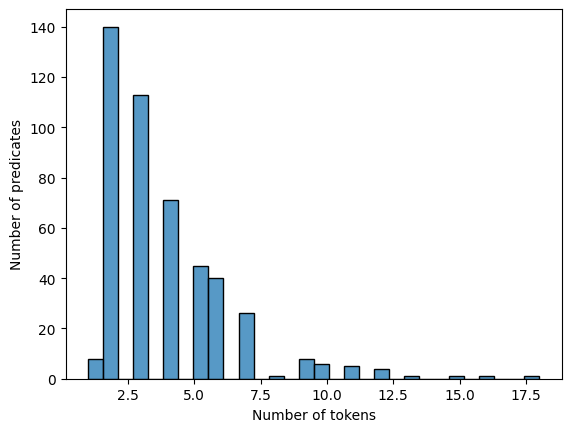

In [459]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.predicate.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank predicates / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)]

unique_predicates = df.predicate.unique().tolist()

print(f"- Total non-blank unique predicate / Non-blank predicates: {len(unique_predicates)}/{len(df)}")

tokenized_predicates = []

for i, p in df.predicate.items():
  tokens = nltk.word_tokenize(p)
  tokenized_predicates.append({
      "predicate": p,
      "length": len(tokens),
      "sentence": df.loc[i].sentence
  })

longest_predicate = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_predicates)
shortest_predicate = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_predicates)

print(f"Longest: {longest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == longest_predicate.get('length')])} results). Example:\n  {longest_predicate}")
print(f"Shortest: {shortest_predicate.get('length')} ({len([p for p in tokenized_predicates if p.get('length') == shortest_predicate.get('length')])} results). Example:\n  {shortest_predicate}\n")

# Show sentences with a specific number of predicate length
# [print(p) for p in tokenized_predicates if p.get('length') == 1]

predicates_lengths: list[int] = [s.get("length") for s in tokenized_predicates]

sbn.histplot(pd.Series(predicates_lengths), bins=30)
plt.xlabel("Number of tokens")
plt.ylabel("Number of predicates")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "so với", "so sánh", "hơn", "chút", "tốt", "nhất", "không" ... are some of the most popular words in predicates.

- Some tuples of words usually stand together, for example:
  - "một chút", "mạnh mẽ", "", "chi tiết", "tiết kiệm", "thế hệ", "thị trường", "xử lý", "tương đồng", "tương tự", "màu sắc", "sắc nét", "sử dụng", "hiện nay", "hiện tại", ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25, "cả" - 2

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [460]:
# Execute this first

## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

nonblank_values = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)].predicate

In [461]:
""" Bag-of-Words """
predicate_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in predicate_bow.items() if i[1] > 3])
print(f"Size of BoW: {len(predicate_bow)}") # largest in the 4 fields of quin

[('hơn', 223), ('đều', 54), ('không', 48), ('có', 43), ('nhiều', 43), ('tốt', 38), ('nhất', 32), ('cao', 29), ('khác', 29), ('lớn', 24), ('biệt', 23), ('như', 22), ('nhau', 20), ('một', 18), ('được', 17), ('chút', 17), ('thế', 16), ('nhỏ', 16), ('nhanh', 15), ('tương', 15), ('hẳn', 15), ('với', 13), ('quá', 13), ('và', 13), ('điểm', 12), ('thấp', 11), ('cấp', 11), ('hiện', 11), ('so', 10), ('ưu', 10), ('phân', 10), ('tự', 10), ('đều', 10), ('vượt', 9), ('sở', 9), ('hữu', 9), ('cùng', 9), ('ở', 9), ('giống', 9), ('khá', 9), ('sự', 9), ('lợi', 9), ('thời', 9), ('trội', 8), ('đôi', 8), ('kém', 8), ('thay', 8), ('đổi', 8), ('gọn', 8), ('đáng', 8), ('rất', 8), ('trang', 7), ('samsung', 7), ('thua', 7), ('bằng', 7), ('mạnh', 7), ('gần', 7), ('cho', 6), ('thể', 6), ('hoàn', 6), ('toàn', 6), ('dễ', 6), ('kể', 6), ('dụng', 6), ('năng', 6), ('của', 6), ('``', 6), ('ít', 6), ('lượng', 6), ('tại', 6), ('cải', 6), ('giá', 5), ('phần', 5), ('pin', 5), ('nổi', 5), ('bật', 5), ('dày', 5), ('trong', 5

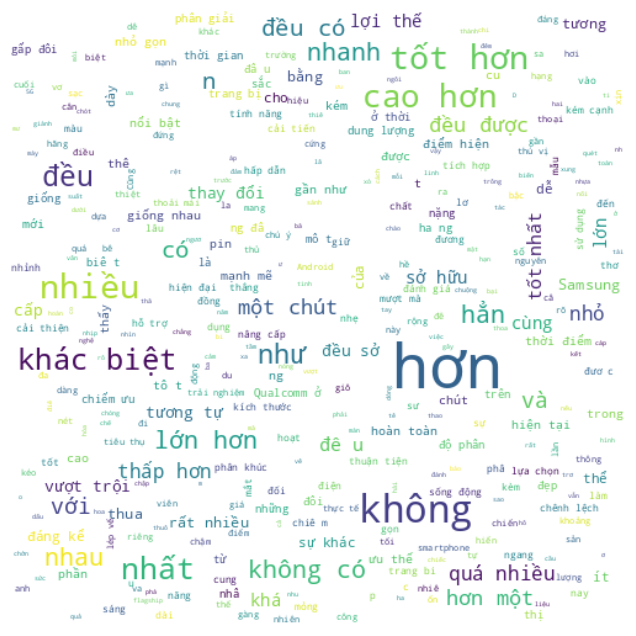

In [462]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist())

In [463]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: khác biệt, không có,...

# filt = [s for s in nonblank_values if re.match(".{0,}hiện.{0,}", s.lower())]

# Use some keywords of the DIF predicates to query predicates of other labels
print("Predicates of 'DIF':")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}.{0,}", str(v).lower())]].query("label == 'DIF'").predicate.unique())

print("\nPredicates of EQL:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'").predicate.unique())

print("\nPredicates of COM:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(không)|(khác)|(chênh).{0,}", str(v).lower())]].query("label.str.contains('COM', na=False)").predicate.unique())

# Query original sentences
# flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'")
# filt

Predicates of 'DIF':
['thay đổi lớn nhất' 'khác biệt' 'có những điểm khác nhau'
 'chẳng có gì khác biệt' 'khác biệt đáng chú ý' 'khác biệt lớn'
 'riêng biệt' 'khác biệt rõ rệt' 'dễ nhận biết và phân biệt'
 'không đi kèm với phần tai thỏ lớn như'
 'không có sạc không dây ngược như' 'thay đổi lớn'
 'không thể trang bị một viên pin có cùng dung lượng' 'không giống nhau'
 'khác biệt so với' 'Điểm khác biệt lớn nhất' 'khá khác biệt'
 'hoàn toàn khác biệt' 'hoàn toàn khác' 'Không giống' 'khác hẳn'
 'khác hẳn nhau' 'không thể làm được điều tương tự' 'khác nhau'
 'dễ phân biệt' 'cải tiến nhỏ']

Predicates of EQL:
['đều không gây mỏi' 'không hề kém cạnh' 'không thua kém'
 'không có nhiều điểm thay đổi' 'không có khác biệt quá nhiều'
 'không chênh lệch nhiều' 'chênh lệch không nhiều' 'không đẹp như'
 'sự khác biệt về hiệu suất thực tế là không đáng kể' 'không kém cạnh'
 'đều không cung cấp' 'không có nhiều thay đổi'
 'không nhận thấy sự khác biệt' 'không có quá nhiều sự khác biệt'
 'không c

#### e. label

Do labels relate to the existences of remaining fields?

List some following information of the 4 remaining fields for each label type:
- predicate: most popular words (may render cloudword)
- frequencies of existences of the 3 fields (subject, object, aspect)
- subject & object: most popular (compound) words (?)


**Idea**:

Due to the fact that:
- predicate always exists in a quintuple
- subject, object & aspect may be absent concurrently

we can scan/identify "predicate candidates" to divide sentences into 3 groups. In each of groups, they will be continously classified into 1 of 9 labels (NON included) by resolving *sub-problems*.
- Group 1: Equal-comparative (ECOM); including EQL & DIF
- Group 2: Comparative (COM); including
  - COM-: negative
  - COM: neutral
  - COM+: positive
- Group 3: Superlative(SUP); including
  - SUP-: negative
  - SUP: neutral
  - SUP+: positive
- Group 4: Non-comparative (NON)

After having 4 groups:
- in the group 1, we'll need to resolve the *binary classification* problem.
- in the group 2 & 3, we'll need to resolve the *Sentimental Classification* problem.


others problems:
- what if 1 sentence provides 2 quintuples that possess the same predicate (subjects/objects/aspect may be diff)? Can the labels be diff in this case?


##### Init & creating helper functions

In [464]:
## Initialize dataset ##
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)
####

blank_counter = len(flattened_df[flattened_df.label.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank labels / All quintuples: {blank_counter}/{TOTAL_DEV_QUINTUPLES}")

labels = flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique().tolist()

groups = ["NON", "COM", "SUP"]
ecom_df = flattened_df[flattened_df.label.str.match("(DIF)|(EQL)", na=False)]
com_df = flattened_df[flattened_df.label.str.contains("COM", na=False)]
sup_df = flattened_df[flattened_df.label.str.contains("SUP", na=False)]

- Total of blank labels / All quintuples: 0/471


In [465]:
def calc_BoW(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect", "predicate"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"

  return make_BoW(df[df.label == label][field])

def calc_frequency(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"


  df_l = df[df.label == label]
  df_f = df_l[df_l[field].str.contains("^.{1,}$", na=False)]

  return len(df_f)

# Test
# calc_frequency("subject", "SUP")

##### i. Counting quintuples & sentences on each type of label
Main function: `relate_labels_with_others(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:
(group 'SUP-' and 'SUP')
        label  num_of_data_points  num_of_sentences
0        COM+                 203               156
1         EQL                 133               115
2        COM-                  51                43
3         DIF                  33                28
4        SUP+                  28                25
5         COM                  18                13
6  SUP- & SUP                   5                 5



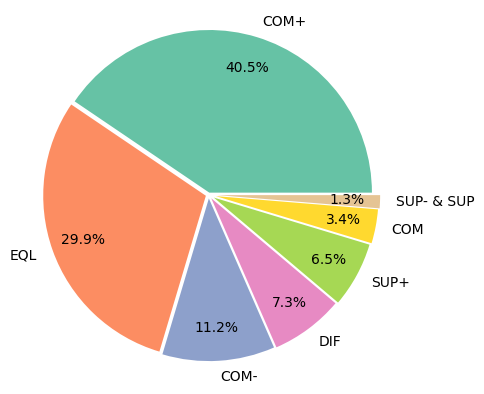

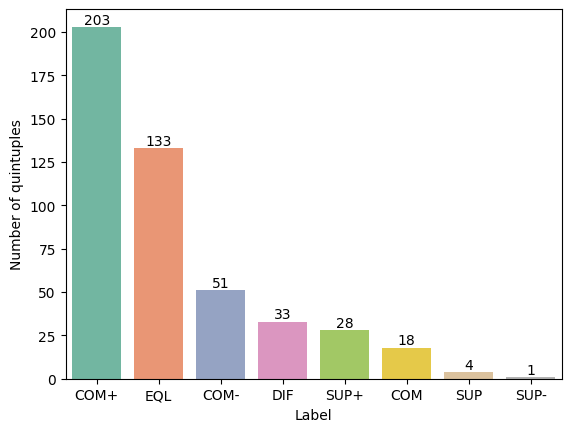

In [466]:
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)

def relate_labels_with_others(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "label": label,
      "num_of_data_points": len(flattened_df[flattened_df.label == label]),
      "num_of_sentences": len(flattened_df[flattened_df.label == label].sentence.unique())

  } for label in list(flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique())]

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:")
  # print(statistic)
  # print()

  ## Group SUP- & SUP (each has 4 sentences) before rendering
  x = statistic.set_index("label").drop(["SUP-", "SUP"]).reset_index()
  minor_data = statistic[statistic.label.str.match("^(SUP-)|(SUP)$", na=False)]#.reset_index()
  minor_data_grouping_point = pd.DataFrame([{
      "label": "SUP- & SUP",
      "num_of_data_points": reduce(lambda acc, val: acc + val, minor_data["num_of_data_points"].tolist()),
      "num_of_sentences": reduce(lambda acc, val: acc + val, minor_data["num_of_sentences"].tolist())
  }])

  x = pd.concat([x, minor_data_grouping_point], ignore_index=True)
  print(f"(group 'SUP-' and 'SUP')\n{x}\n")

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06]

  plt.pie(x["num_of_sentences"], labels=x.label.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1.1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  # plt.title('Số lượng data point trên từng label')
  plt.show()
  print()

  plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
                      order=list(flattened_df.value_counts("label").index),
                      palette=color_pallete)
  plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  plot.bar_label(plot.containers[0])

  plt.show()

relate_labels_with_others(flattened_df)

##### ii. Counting quintuples & sentences in each group
Main function: `relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each group:
                   group  num_of_data_points  num_of_sentences
1      COM (Comparative)                 272               198
2  NON (Non-comparative)                 166               142
0      SUP (Superlative)                  33                30



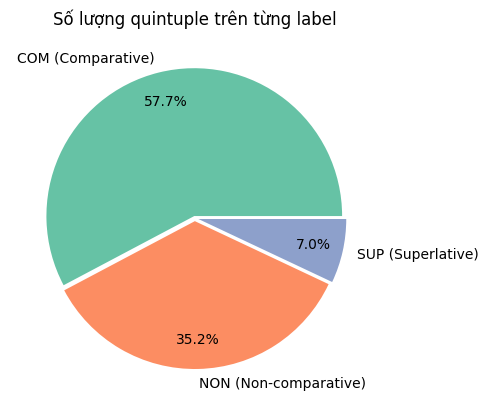

In [467]:
flattened_df = pd.DataFrame(FLAT_DEV_DATASET)

def relate_groups_with_quin_and_sent(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "group": "SUP (Superlative)",
      "num_of_data_points": len(sup_df),
      "num_of_sentences": len(sup_df.sentence.unique())
  }]

  statistic.append({
      "group": "COM (Comparative)",
      "num_of_data_points": len(com_df),
      "num_of_sentences": len(com_df.sentence.unique())

  })

  statistic.append({
      "group": "NON (Non-comparative)",
      "num_of_data_points": len(ecom_df),
      "num_of_sentences": len(ecom_df.sentence.unique())
  })

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each group:")
  print(statistic)
  print()

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025]

  plt.pie(statistic["num_of_data_points"], labels=statistic.group.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  plt.title('Số lượng quintuple trên từng label')
  plt.show()
  print()

  # plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
  #                     order=list(flattened_df.value_counts("label").index),
  #                     palette=color_pallete)
  # plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  # plot.bar_label(plot.containers[0])

  # plt.show()

relate_groups_with_quin_and_sent(flattened_df)

##### iii. Relate labels to the remaining quintuple fields

**Labels vs predicates**
(Common characteristics)
- Predicates in general show key opinions of authors/reviewers about the comparisons between 2 products/product lines...
- In predicates, adverbs along with adjectives takes up most of the words. Specifically, some of them are:
  - Adverbs of degree: hơi, rất, khá, nhất
  - Adverbs of manner: tốt
  - Adjectives (may be specific to context): mạnh mẽ, khác biệt

**Labels vs subjects**

**Labels vs objects**

**Labels vs aspects**


###### Non-comparative group

- "EQL" predicates (287q):
  - Keywords:
    - Adj:
      - không có .+ khác biệt
      - không có .+ chênh lệch
      - Tương tự/tương đồng
      - Ngang/giống/bằng nhau
    - Adverb of degree: (không) đáng kể, lớn, nhiều
      ...

- "DIF" predicates (58q):
  - Keywords:
    - Adj: khác biệt, khác nhau, không bằng (như)
    - Adv of degrees: rõ ràng,
    
      ...

- There're ambiguities in classifying label based on predicates.
For example, the sentences with predicate "không có khác biệt" (or similar ones) are mostly considered as "EQL", but sometimes are sorted into "DIF".

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|4437|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||bộ vi xử lý|tương tự nhau|EQL|
|4438|Do sức mạnh đến từ bộ vi xử lý tương tự nhau nên không có nhiều sự khác biệt về khả năng tiết kiệm điện năng \.|||khả năng tiết kiệm điện năng|không có nhiều sự khác biệt|DIF|
|4442|des : Không có nhiều sự khác biệt về khả năng tiết kiệm điện năng|||khả năng tiết kiệm điện năng|Không có nhiều sự khác biệt|EQL|


Label 'DIF' (33):
Some examples:
['thay đổi lớn nhất' 'khác biệt' 'có những điểm khác nhau'
 'chẳng có gì khác biệt' 'khác biệt đáng chú ý' 'khác biệt lớn'
 'riêng biệt' 'khác biệt rõ rệt' 'dễ nhận biết và phân biệt'
 'không đi kèm với phần tai thỏ lớn như'
 'không có sạc không dây ngược như' 'thay đổi lớn'
 'không thể trang bị một viên pin có cùng dung lượng' 'không giống nhau'
 'khác biệt so với' 'Điểm khác biệt lớn nhất' 'khá khác biệt'
 'hoàn toàn khác biệt' 'hoàn toàn khác' 'Không giống' 'khác hẳn'
 'khác hẳn nhau' 'không thể làm được điều tương tự' 'khác nhau'
 'dễ phân biệt' 'cải tiến nhỏ']

- Field 'subject':
  + Freq: 31
  + BoW:
    {'galaxy': 10, 's22': 6, 'hai': 5, 'chiếc': 5, 'iphone': 5, 'điện': 4, 'thoại': 4, 'google': 4, 'này': 3, '11': 3, 'xiaomi': 2, 'pixel': 2, 'z': 2, 's21': 1, '+': 1, 'a12': 1, 'sản': 1, 'phẩm': 1, 'm31s': 1, 's10': 1, '5g': 1, 'ultra': 1, 'oneplus': 1, '10': 1, 'pro': 1, 'mi': 1, '12': 1, 'samsung': 1, 'a24': 1, '7a': 1, 'thiết': 1, 'bị': 1, 

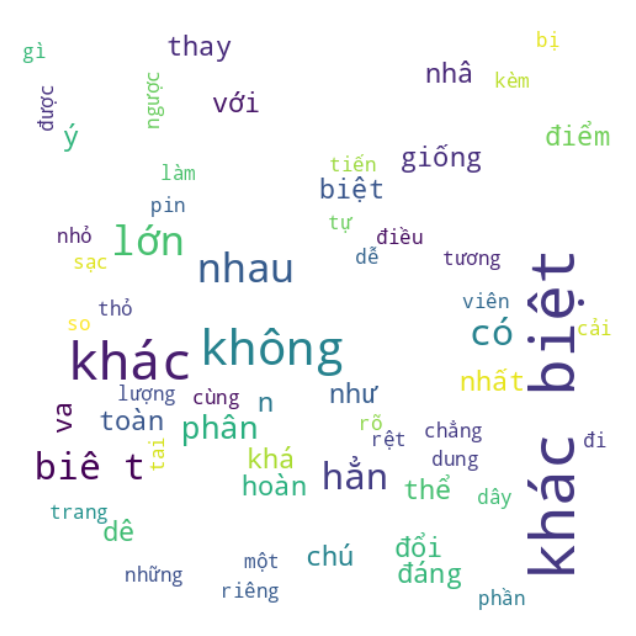




Label 'EQL' (133):
Some examples:
['đều không gây mỏi' 'đều sở hữu' 'không hề kém cạnh' 'đều cho ra'
 'đều hỗ trợ' 'đều đảm bảo' 'đều được hỗ trợ' 'Cũng như'
 'chiếc smartphone cuối cùng cho anh trải nghiệm pin tốt đến vậy'
 'có nhiều điểm tương đồng với nhau'
 'có nhiều điểm giống nhau nếu nhìn từ mặt trước' 'đều được hãng trang bị'
 'đều được làm từ chất liệu nhựa' 'tương đương nhau' 'đều được tích hợp'
 'đều được Samsung tích hợp' 'không thua kém'
 'không có nhiều điểm thay đổi' 'vẫn giữ được' 'đều có'
 'không có khác biệt quá nhiều' 'cùng' 'không chênh lệch nhiều'
 'chênh lệch không nhiều' 'tương tự như' 'tương tự' 'không đẹp như'
 'hoàn toàn ngang bằng' 'đều cho thấy' 'đều sử dụng' 'đều dựa vào'
 'đều dựa vào máy quét dấu vân tay dưới màn hình'
 'đều hoàn thành công việc tốt như nhau' 'đều đi kèm'
 'sự khác biệt về hiệu suất thực tế là không đáng kể' 'cũng hỗ trợ'
 'cân tài cân sức'
 'đều là những thiết bị hàng đầu một thời của Samsung'
 'đều được sử dụng' 'đều đượ

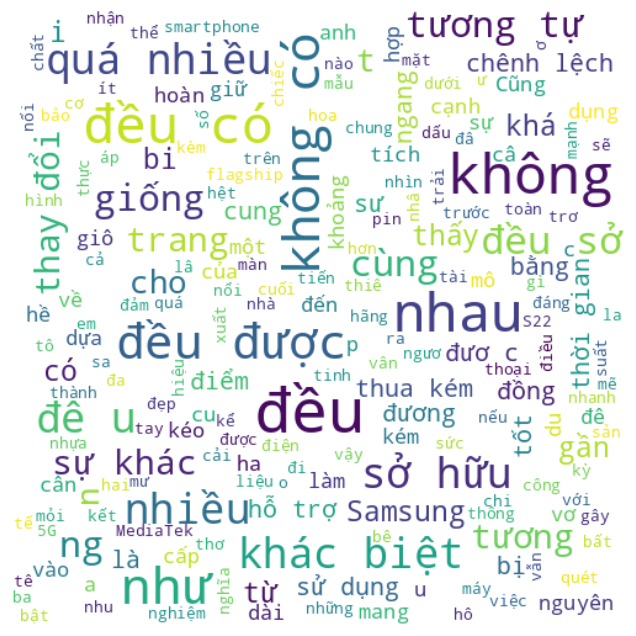

In [468]:
for label in ["DIF", "EQL"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  print(df_l.predicate.unique())
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Comparative group

- "COM+" predicates - 500q (*positive*):
  - Keywords: "hơn" - 415, tốt - 76, cao - 53, nhiều - 45

- "COM" predicates - 21q (*neutral*):
  - Keywords: "hơn" - 19.

- "COM-" predicates - 107q (*negative*):
  - Keywords: "hơn" - 64, thấp - 21, kém - 19, không - 18, thua - 8, yếu - 8


Label 'COM+' (203):
Some examples:
- vượt trội
- được đánh giá cao so với
- có phần cứng cáp hơn
- có phần nặng hơn đôi chút
- hài hòa hơn
- có phần nhỉnh hơn
- cao hơn
- nhanh hơn
- gọn gàng hơn
- trông hấp dẫn hơn

- Field 'subject':
  + Freq: 176
  + BoW:
    {'galaxy': 49, 'iphone': 24, 'samsung': 21, '13': 17, 'điện': 12, 'thoại': 12, 'xiaomi': 12, 'chiếc': 11, 'oppo': 10, 'a31': 9, 'của': 9, '5g': 9, 'z': 9, 'này': 8, 's22': 8, '11': 8, 'f9': 8, 'nó': 7, 's10': 7, 'pixel': 6, 's23': 6, 'hình': 5, 'các': 5, 'pro': 5, 'sản': 5, 'phẩm': 5, 'mi': 5, 'vivo': 5, 'google': 5, 'fold': 5, '2': 5, 'max': 4, 'ultra': 4, 'oneplus': 4, '12': 4, 'a73': 4, 'flip': 4, 'chất': 3, 'màn': 3, 'a13': 3, '4gb': 3, 'camera': 3, 'táo': 3, 'khuyết': 3, 'y21': 3, 'máy': 3, 'nhà': 3, 'apple': 3, 'xs': 3, 'a33': 2, 'a32': 2, 's21': 2, '+': 2, 'a12': 2, 'lượng': 2, 'hiển': 2, 'thị': 2, 'cổng': 2, 'sạc': 2, 'type': 2, 'c': 2, 'mặt': 2, 'sau': 2, 'trước': 2, 'thép': 2, 'không': 2, 'gỉ': 2, 'trên': 2, 'mẫu': 2,

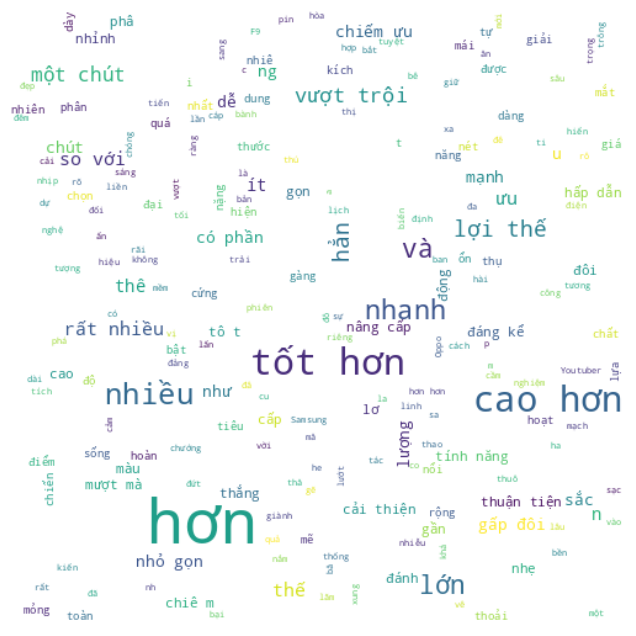




Label 'COM' (18):
Some examples:
- không quá dày như
- lớn hơn đáng kể
- tối hơn
- sáng hơn
- sáng hơn thực tế
- nhỏ hơn
- ngắn và mỏng hơn đáng kể
- dày hơn
- nặng hơn
- lớn hơn

- Field 'subject':
  + Freq: 16
  + BoW:
    {'galaxy': 6, 'google': 3, 'iphone': 2, 'phiên': 2, 'a03s': 2, 'chiếc': 2, 'flagship': 2, 'của': 2, 'máy': 1, 'xiaomi': 1, '12': 1, 'bản': 1, '2022': 1, 'màn': 1, 'hình': 1, '13': 1, 'nó': 1, 'pixel': 1, '6': 1, 'bản': 1, 's23': 1, 'z': 1, 'flip': 1}
- Field 'object':
  + Freq: 13
  + BoW:
    {'xiaomi': 3, 'vivo': 2, 'y21': 2, 'iphone': 2, '13': 2, 'những': 1, 'điện': 1, 'thoại': 1, 'khác': 1, 'galaxy': 1, 'mi': 1, '11': 1, 's21': 1, 'pixel': 1, '6': 1, 'xu': 1, 'hướng': 1, 'hiện': 1, 'nay': 1}
- Field 'aspect':
  + Freq: 14
  + BoW:
    {'màn': 4, 'hình': 4, 'ảnh': 3, 'chụp': 2, 'kích': 2, 'thước': 2, 'hai': 2, 'bên': 2, 'cạnh': 2, 'viền': 2, 'phần': 1, 'cằm': 1, 'màu': 1, 'sắc': 1, 'tương': 1, 'trọng': 1, 'lượng': 1, 'thiết': 1, 'lập': 1, 'máy': 1}
- Field '

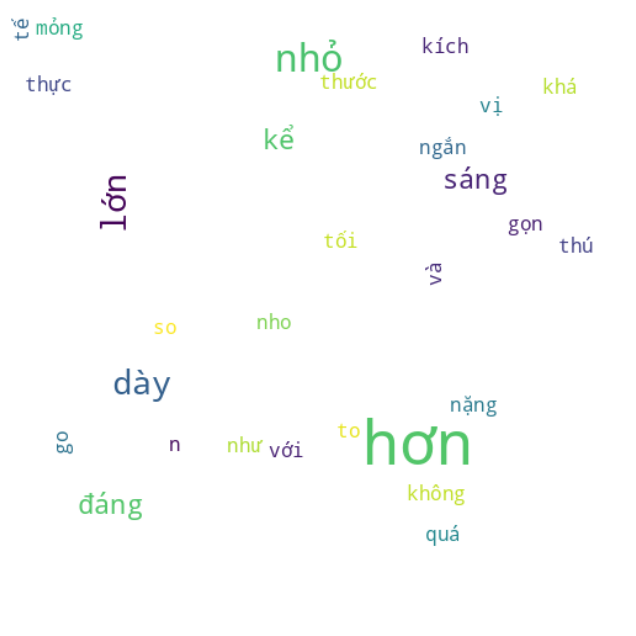




Label 'COM-' (51):
Some examples:
- độ phân giải thấp hơn
- thấp hơn
- thua kèm đôi chút
- lớn hơn
- không đẹp bằng
- hạn chế hơn
- hơi kém cạnh một chút
- thua thiệt hơn
- không thể so sánh với
- nặng hơn

- Field 'subject':
  + Freq: 46
  + BoW:
    {'iphone': 17, 'galaxy': 9, '12': 8, 'nó': 5, 'của': 4, 'samsung': 4, 'a03s': 3, '13': 3, 'chiếc': 3, 'camera': 2, 'pin': 2, 's22': 2, 'máy': 2, 'google': 2, 'pixel': 2, '7a': 2, 'z': 2, 'đời': 2, 'mới': 2, 'sau': 1, 'chụp': 1, 'ảnh': 1, '64mp': 1, 'giới': 1, 'hạn': 1, 'rung': 1, 'chất': 1, 'liệu': 1, 'nhôm': 1, 'viên': 1, 'vivo': 1, 't1': 1, '5g': 1, 'a73': 1, 'sản': 1, 'phẩm': 1, 'những': 1, 'mẫu': 1, 'điện': 1, 'thoại': 1, 'android': 1, 'tầm': 1, 'trung': 1, 'trên': 1, 'màn': 1, 'hình': 1, 'phụ': 1, 'flip': 1, 'fold': 1, '2': 1, '11': 1, 'các': 1, 'đại': 1, 'diện': 1}
- Field 'object':
  + Freq: 36
  + BoW:
    {'thủ': 7, 'đối': 5, 'galaxy': 4, 'mi': 4, '11': 4, 'của': 4, 'm31s': 3, 'xiaomi': 3, 'oneplus': 3, '16mp': 2, 'định': 2, '

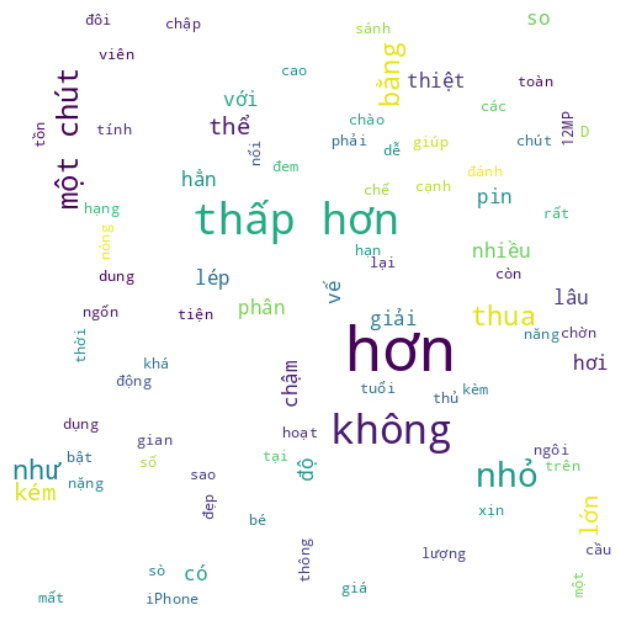

In [469]:
for label in ["COM+", "COM", "COM-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

###### Superlative group

- "SUP+" predicates - 107 (*positive*):
  - Keywords: "nhất" - 85, tốt - 33, nay - 28, hiện - 25, cao - 15, mạnh - 14

- "SUP" predicates - 4 (*neutral*):
  - Keywords: "nhất" - 4, lớn - 2

- "SUP-" predicates - 5 (*negative*):
  - Keywords: "nhất" - 4, nhỏ - 2, đắt - 1



Label 'SUP+' (28):
Some examples:
- ưa chuộng nhiều nhất
- mẫu smartphone tốt nhất ở năm 2021
- nổi bật nhất ở tầm giá này
- đứng ở hạng chót trong những đối thủ cùng phân khúc
- hàng đầu một thời của Samsung
- " xịn xò " nhất
- mới nhất đối với mỗi dòng
- điện thoại Android tốt nhất
- tốt nhất trên thị trường hiện nay
- tốt nhất cho đến nay

- Field 'subject':
  + Freq: 26
  + BoW:
    {'galaxy': 6, 'màn': 4, 'hình': 4, 'đây': 3, 'nó': 2, '5g': 2, 'hai': 2, 'samsung': 2, 'snapdragon': 2, '8': 2, 'gen': 2, 'rộng': 2, 'điện': 2, 'thoại': 2, 'màu': 1, 'tím': 1, 's21': 1, '+': 1, 'm31s': 1, 's10': 1, 'note': 1, '9': 1, 'cả': 1, 'phiên': 1, 'bản': 1, 'hệ': 1, 'điều': 1, 'hành': 1, 'cả': 1, 'điện': 1, 'thoại': 1, 'xiaomi': 1, 'mi': 1, '11': 1, 'vivo': 1, 't1': 1, 's22': 1, '1': 1, 'chiếc': 1, 'này': 1, 'cảm': 1, 'biến': 1, 'sản': 1, 'phẩm': 1, 'mẫu': 1, 'cao': 1, 'cấp': 1, 'tiếp': 1, 'theo': 1, 'của': 1, '2': 1, 's23': 1}
- Field 'object':
  + Freq: 3
  + BoW:
    {'những': 1, '

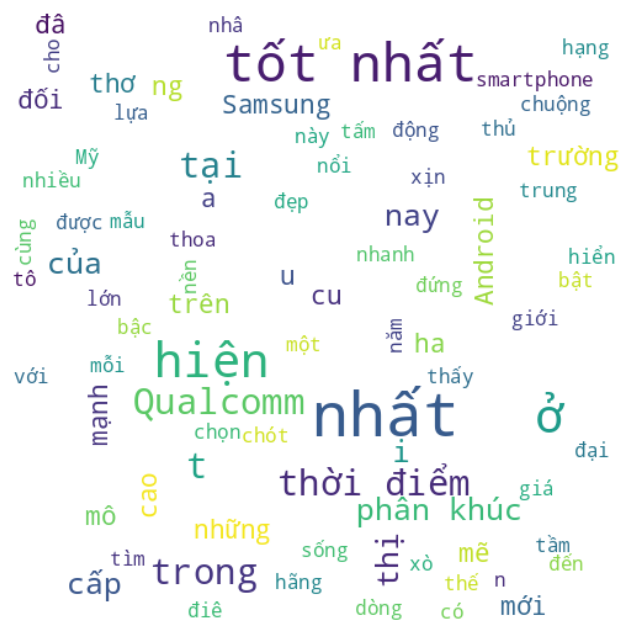




Label 'SUP' (4):
Some examples:
- mẫu điện thoại giá rẻ mới nhất
- nhất thời điểm hiện tại
- nhiều “ ẩn số ” nhất trong lần ra mắt sản phẩm mới này của Apple
- sớm bậc nhất

- Field 'subject':
  + Freq: 4
  + BoW:
    {'galaxy': 2, 'samsung': 1, 'a24': 1, 'nhưng': 1, 'thiết': 1, 'bị': 1, 'này': 1, 'iphone': 1, '12': 1, 'mini': 1, 's22': 1, 'series': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 3
  + BoW:
    {'được': 1, 'quan': 1, 'tâm': 1, 'ẩn': 1, 'số': 1, 'sử': 1, 'dụng': 1, 'snapdragon': 1, '8': 1, 'gen': 1, '1': 1}
- Field 'predicate':
  + BoW:
    {'nhất': 4, 'mới': 2, 'mẫu': 1, 'điện': 1, 'thoại': 1, 'giá': 1, 'rẻ': 1, 'thời': 1, 'điểm': 1, 'hiện': 1, 'tại': 1, 'nhiều': 1, '“': 1, 'ẩn': 1, 'số': 1, '”': 1, 'trong': 1, 'lần': 1, 'ra': 1, 'mắt': 1, 'sản': 1, 'phẩm': 1, 'này': 1, 'của': 1, 'apple': 1, 'sớm': 1, 'bậc': 1}



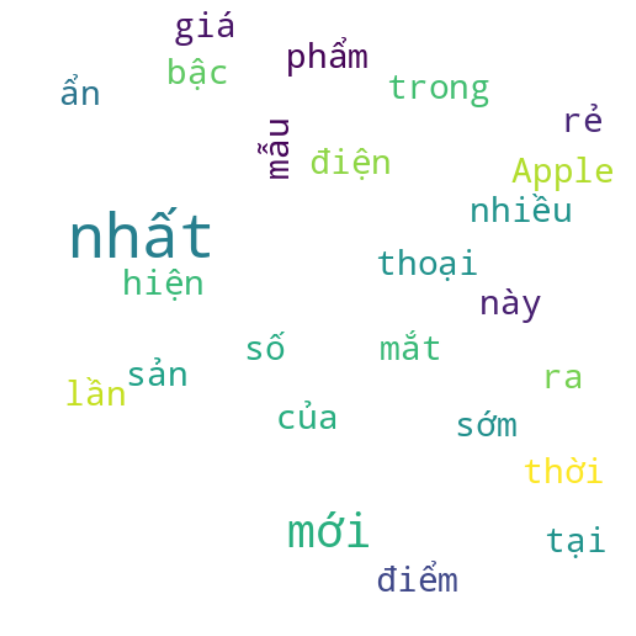




Label 'SUP-' (1):
Some examples:
- đứng ở cuối

- Field 'subject':
  + Freq: 1
  + BoW:
    {'nó': 1}
- Field 'object':
  + Freq: 0
  + BoW:
    {}
- Field 'aspect':
  + Freq: 0
  + BoW:
    {}
- Field 'predicate':
  + BoW:
    {'đứng': 1, 'ở': 1, 'cuối': 1}



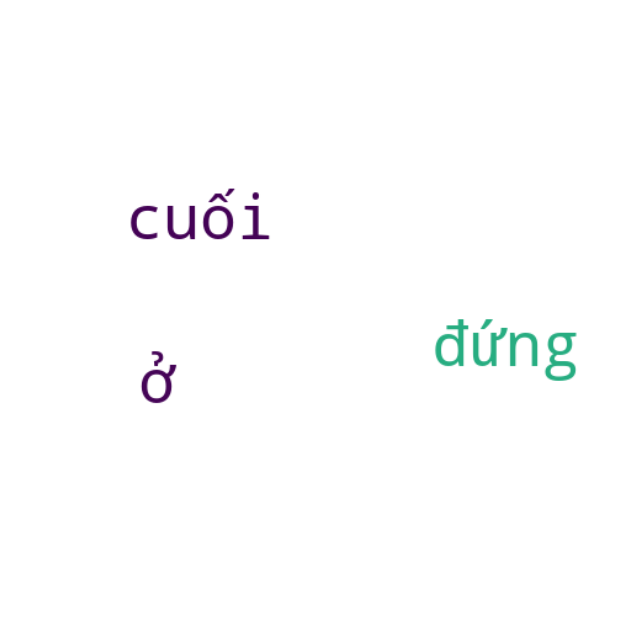

In [470]:
for label in ["SUP+", "SUP", "SUP-"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

#### Relate the fields to each others



- Incorrect object?

|index|sentence|subject|object|aspect|predicate|label|
|---|---|---|---|---|---|---|
|831|Về chất lượng hiển thị , so sánh iPhone XS và iPhone 11 thì iPhone XS có phần trội hơn \.|iPhone XS|iPhone XS|chất lượng hiển thị|có phần trội hơn|COM+|
|1476|Với điện thoại màn hình gập Galaxy Z Fold 4 sẽ mang đến không gian hiển thị linh hoạt hơn với 2 màn hình \.|điện thoại màn hình gập Galaxy Z Fold 4|điện thoại màn hình gập Galaxy Z Fold 4|không gian hiển thị|linh hoạt hơn|COM+|

In [471]:
# subject == object: 130
# 128 are either DIF or EQL; 2 is COM+
# flattened_train_df[flattened_train_df.predicate.notna()].query("subject == object & subject.str.contains('.{1,}', na=False)")



### 4. Exporting dataset

In [472]:
# This output dataset should be result of the "shallow" cleaning process
# performed in the section "II.2. Analyzing sentences" .

train_df.to_csv("post_analysis_development_dataset.csv", index=False)

## III. Analysis on test dataset

In [ ]:
# TEST_DF.drop("quintuples", axis=1, inplace=True)
print(len(TEST_DF) == 1732)
TEST_DF.loc[[i for i, v in TEST_DF.sentence.items() if len(nltk.word_tokenize(v)) in range(6)]] # 0-3 chars: 54

Conclusions: **(not modified yet)**
- Most of the sentences start with a capitalized word and end with a '.' (1004).
- Some are not complete sentence, which may start with not-capitalized word and may not contain subject. e.g.
- Some are combined from 2 sentences. e.g. "".
- Removing characters
  - Special-character candidates: ". . .", " . " (sent separator; rm if num of sent isn't concerned),
  -

In the section 1, we can see an unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of zero-quin sentences (3359) is about *4 times* larger than number of sentences with quin (812).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, by which we may have some bases for making *data cleaning* decisions.

Result: 2819 zero-quin sentences left (540 deleted).

In [ ]:
## Initialize dataset
# 'test_df' now store the data from test dataset
# temporarily ignore the variable name 'test_df'; may be changed later
test_df = TEST_DF.copy()
print(f"Original test dataset's size (before modified): {len(test_df)}")

Original test dataset's size (before modified): 1732


#### General stats (before modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Conclusion:
- The distribution is quite similar to training dataset.

- Sentence size may be affected by a non-trivial number of non-alphanumeric characters (bracket, comma, quote, etc) (infered from observing both histogram & dataset)
- Sentences's size is mainly in range 10-35, means=18.3, median=17

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}

(Test query) 129
       num_of_tokens
count    1732.000000
mean       19.116051
std        12.925724
min         1.000000
25%         9.000000
50%        18.000000
75%        26.000000
max        72.000000


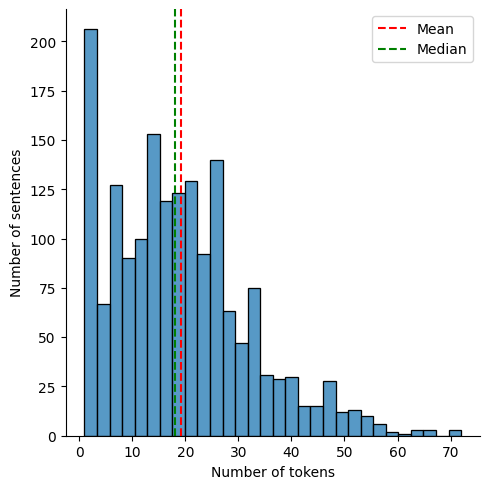

In [ ]:
# @title
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in test_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 82; “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin
print()

df = test_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]

print(f"(Test query) {len(df.query('num_of_tokens >= 8 & num_of_tokens <= 10'))}")
print(df.describe())

## Render histogram
sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist")

plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### a. "Sentences" start with numbers
Conclusion: Most of "sentences" start with numbers (section number, quantity) contain only section numbers or along with titles. They don't contain any quintuple.

⇒ Remove all.

In [ ]:
# test_df = TEST_DF.copy()

print(f"Size of dataset before modified: {len(test_df)}")

# Remove "sentences" start with numbers (\d*[(\\.[\d]*)]+)
test_df.drop(test_df[test_df.sentence.str.contains("^\d*[(\\.\d*)]+\W{1,}")].index.tolist(), inplace=True) # 105

print(f"Size of dataset after modified: {len(test_df)}")

Size of dataset before modified: 1732
Size of dataset after modified: 1670


#### b. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``test_df.loc[test_df.sentence.drop_duplicates().index.tolist()]``

(should do this after all other steps)

In [ ]:
# @title
""" Check if any sentence is duplicated """

test_df = TEST_DF.copy()

print(f"Size of the dataset before modified: {len(test_df)}")

dups = test_df[test_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

# remove duplicates
test_df = test_df.loc[test_df.sentence.drop_duplicates().index.tolist()]
print(f"Size of dataset after modified: {len(test_df)}")

Size of the dataset before modified: 1732
Number of duplicates: 205
Size of dataset after modified: 1527


#### c. Special sentences
- Stats: (original/unique/quin_owner)
  - title: 44/44/0. "title : " is always at the first position of the sentences.
  - des: 499/216/24(23 unique)
  - alt: 500/332/1;
  - questions: 126/.../0. All sents containing "?" are questions.

- **Conclusion 2**: the sequences '(alt : )|(des : )|(title : )' does not contribute any meaning to a sentence, thus should be filtered out before processing.

- **Conclusion 3**:  
  - In questions and titles, there's no sentence that has at least 1 quintuple.
  - In "alt" sentences, there's only 1 sent that has quintuple (2).

  => Propose deleting:
    - All '?' & 'title' sentences: 170
    - 'alt' & 'des' sentences: only blank-sentence values (due to the existences of some ambiguous sentences)

- **Conclusion 4**: The sentences "starting with 'des : ', 'alt : ' & having at least 1 quin" need to be kept.

- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset (there're ... duplicates in total)
=> Continue removing duplicates by the recommended command above.

In [ ]:
# @title
"""
In this section (and maybe others), I define a "special sentence"
is a sentence containing "alt", "des", "title" or "?".
Purpose: Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences may be filtered out (or not) before examining.
"""

test_df = TEST_DF.copy()

questions_and_titles = test_df[test_df.sentence.str.contains("(\?)|(title)")]
special_sentences = test_df[test_df.sentence.str.contains("(alt)|(des)")]
print()

## Questions & titles
# print(len(test_df[test_df.sentence.str.contains("title")]))
# print(len(test_df[test_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.\n")

# Remove questions and titles
test_df.drop(questions_and_titles.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des :', 'alt :': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des :', 'alt :') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")

dups_bef = len(test_df[test_df.sentence.duplicated()])

print(f"Dups before removing 'des :' & 'alt :': {dups_bef}")

# Substitute "(des : )|(alt : )" with "" and replace old strings with those in test_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des ?:? ?)|(alt ?:? ?)", "", special_sentences.iloc[i].sentence)
  test_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(test_df[test_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{test_df[test_df.sentence == new_sent]}\n")

tmp = len(test_df[test_df.sentence.duplicated()])

print(f"Dups after removing 'des :' & 'alt :': {tmp}")
print(f"""
Conclusion 5: after removing 'des :', 'alt :', the result sentences may have
been existed in the original training dataset ({tmp - dups_bef} increased)"""
)

test_df = test_df.loc[test_df.sentence.drop_duplicates().index.tolist()] #

# print(f"\nDups after being removed for the 2nd time: {len(test_df[test_df.sentence.duplicated()])} (test)")
print(f"\nSize of the dataset after modified: {len(test_df)}")


Sentences containing '?' and/or 'title : ' (63) and having quintuple: 0
=> Conclusion 3: The sentences containing '?' and/or 'title : ' should be removed.

Number of special sentences starting with 'des :', 'alt :': 369
Number of special sentences (starting with 'des :', 'alt :') having at least 1 quin: 0
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des :' & 'alt :': 203


<ipython-input-134-9150db724c88>:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  questions_and_titles = test_df[test_df.sentence.str.contains("(\?)|(title)")]
<ipython-input-134-9150db724c88>:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  special_sentences = test_df[test_df.sentence.str.contains("(alt)|(des)")]


Dups after removing 'des :' & 'alt :': 297

Conclusion 5: after removing 'des :', 'alt :', the result sentences may have
been existed in the original training dataset (94 increased)

Size of the dataset after modified: 1372


#### d. Others


In [ ]:
# Find data points from 2 sentences:
# Total: 51 (after cleaning section titles & other sentences starting with number); having quin: 25 (unique: 17)

# remove sentences start with number
df = test_df.copy()

query = [i for i, s in df.sentence.items() if regex.match(r"", s)]
twos = df[df.sentence.str.contains("[\\.]( \\.){0,} .*$")]#.query("label.isna()")
twos
# ending_dots = df[df.sentence.str.contains(r" \.$")]#.query("label.isna()")
# ending_dots
# old = df[df.sentence.str.contains(".{1,} [\\.] .{1,}")]
# old.drop(twos.index.tolist())
df[df.sentence.str.contains(":")]

#### General stats (after modified)

##### Distribution of sentence size

Sentence size is calculated by number of tokens.

Sentence with largest number of tokens:
{'sentence': 'Hứa hẹn lớn của Xiaomi 13 Pro chắc chắn là về máy ảnh : bạn có cảm biến máy ảnh chính loại 1 inch , lớn hơn những gì bạn có trên Galaxy và về mặt lý thuyết sẽ hoạt động tốt hơn vào ban đêm và bạn có khả năng thu phóng 3,2 lần máy ảnh có một số siêu năng lực mà chúng ta sẽ nói đến dưới đây .', 'num_of_tokens': 72}
Sentence with smallest number of tokens:
{'sentence': '', 'num_of_tokens': 0}

(Test query)                              sentence quintuples  num_of_tokens
4             Hãy cùng theo dõi nhé !       None              6
13     Thiết kế Samsung Galaxy A33 5G       None              6
116      Mua hàng chính hãng tại TGDĐ       None              6
166   Tổng quan về Samsung Galaxy A12       None              6
169              Samsung Galaxy A12 .       None              4
...                               ...        ...            ...
1634        Thiết kế mỗi người một vẻ       None              6
1644       Màn hình có điểm

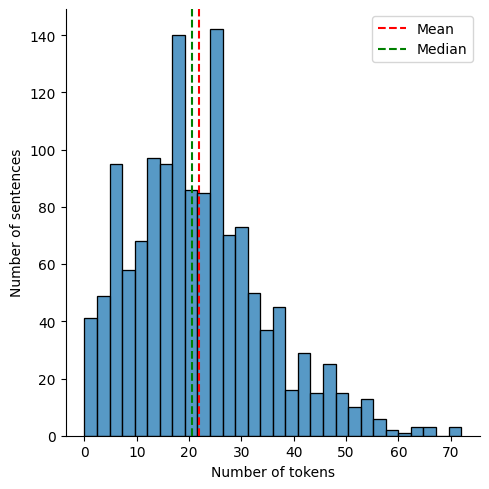

In [ ]:
## Size of sentences

sents: list[dict] = [{
    "sentence": sentence,
    "num_of_tokens": len(nltk.word_tokenize(sentence))
} for sentence in test_df.sentence.tolist()]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)

print("Sentence with largest number of tokens:")
print(largest_sent) # 72
print("Sentence with smallest number of tokens:")
print(smallest_sent) # 8
print()

df = test_df.copy()
df["num_of_tokens"] = [s.get("num_of_tokens") for s in sents]

print(f"(Test query) {(df.query('num_of_tokens >= 4 & num_of_tokens <= 6'))}")
print(df.describe())

sbn.displot(data=df, x="num_of_tokens", bins=30, kind="hist")

plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.axvline(x=np.mean(df.num_of_tokens), color='red', linestyle='--', label='Mean')
plt.axvline(x=np.median(df.num_of_tokens), color='green', linestyle='--', label='Median')
plt.legend()

plt.show()

#### d. Exporting dataset

In [ ]:
TEST_DF.drop("quintuples", axis=1).to_csv("test_dataset.csv", index=False)

## Problems

Problems with data? Which needs to be cleaned? Solutions?
- Imbalance (having at least 1 vs no quintuple; 'label' biases "COM+" value)
  
  -> removing, sampling & augmentation ... ?

- Difference in definition of "word" & "token" in Vietnamese vs English; most of product names is English while remaining is Vietnamese.
  - how to handle Vietnamese compound noun? segmentation. -> which lib or technique? consistency between sentence & quintuple (especially product name, ...)?
  - stopwords? which ones should be removed? (considered in VNese)
- Lack of data (or unimportant data...), especially in lines containing "des:", "title:"...

  ->

- Duplicate: some sentences are quite similar; they even are substring of others.

  ->

